# **TELCO CUSTOMER CHURN PREDICTION**


### **Project Overview**

The primary objective of this project is to develop a predictive model that accurately identifies customers who are likely to churn in the near future. By leveraging historical data, the model aims to help the telecommunications company proactively retain at-risk customers through targeted interventions and personalized offers.

I will be leveraging the widely used CRISP-DM Framework for this project.

The CRISP-DM (Cross-Industry Standard Process for Data Mining) framework is a widely used methodology for data mining and data analysis projects. It provides a structured approach for planning and executing data projects. The process is cyclic and iterative, consisting of six phases:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

## **Business Understanding**


### **Hypotheses**
- Hypothesis 1: Customers with longer tenure are less likely to churn.


- Hypothesis 2: Customers with longer contacts are less likely to churn.


### **Important Business Questions**

1. What are the main reasons behind customer churn?

   - Understanding the primary factors contributing to churn can help in addressing the root causes and developing effective retention strategies.


2. Which customer demographics (e.g., age, gender, marital status) are more likely to churn?

   - Identifying specific demographic groups that are more prone to churn can help tailor marketing and retention efforts to those segments.


3. How does the length of the customer's tenure impact their likelihood to churn?

   - Analyzing the relationship between tenure and churn can reveal whether long-term customers are more loyal and what measures can be taken to extend customer tenure.


4. What role do service issues (e.g., technical support, service outages) play in customer churn?

   - Assessing the impact of service quality on churn can guide improvements in customer support and service reliability.

In [165]:
import os
import joblib
import scipy.stats as stats

# Data Manipulation and Connection
import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning, Preprocessing & Hyperparameter Tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from functools import partial

# Model Persistence
import joblib

# Other Utilities
from warnings import filterwarnings
filterwarnings('ignore')

Then I will go ahead to get my credentials needed to connect to the database, from my .env file.

In [82]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

#create connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [83]:
connection = pyodbc.connect(connection_string)

## **Data Understanding**

The data for this projects has been divided into 3. The first 2 data sets are for training and evaluation the machine learning model  while the last data set is for testing the model.

The first 3000 records of the dataset can be found in a database I will be connecting to using some credentials.

The second part of the data is hosted on a GitHub Repository in a file called LP2_Telco-churn-second-2000.csv.

The final 2000 records of the data set needed for this project can be found in a OneDrive. The filed is named Telco-churn-last-2000.xlsx. 

Below are the columns and their descriptions:

| Attribute          | Description                                                    |
|--------------------|----------------------------------------------------------------|
| Gender             | Whether the customer is a male or a female                     |
| SeniorCitizen      | Whether a customer is a senior citizen or not                  |
| Partner            | Whether the customer has a partner or not (Yes, No)            |
| Dependents         | Whether the customer has dependents or not (Yes, No)           |
| Tenure             | Number of months the customer has stayed with the company      |
| PhoneService       | Whether the customer has a phone service or not (Yes, No)      |
| MultipleLines      | Whether the customer has multiple lines or not                 |
| InternetService    | Customer's internet service provider (DSL, Fiber Optic, No)    |
| OnlineSecurity     | Whether the customer has online security or not (Yes, No, No Internet) |
| OnlineBackup       | Whether the customer has online backup or not (Yes, No, No Internet) |
| DeviceProtection   | Whether the customer has device protection or not (Yes, No, No internet service) |
| TechSupport        | Whether the customer has tech support or not (Yes, No, No internet) |
| StreamingTV        | Whether the customer has streaming TV or not (Yes, No, No internet service) |
| StreamingMovies    | Whether the customer has streaming movies or not (Yes, No, No Internet service) |
| Contract           | The contract term of the customer (Month-to-Month, One year, Two year) |
| PaperlessBilling   | Whether the customer has paperless billing or not (Yes, No)    |
| PaymentMethod      | The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic)) |
| MonthlyCharges     | The amount charged to the customer monthly                     |
| TotalCharges       | The total amount charged to the customer                       |
| Churn              | Whether the customer churned or not (Yes or No)                |


In [84]:
# query the database for the first part of the data and assign it a variable name 'df1'
query = "Select * from dbo.LP2_Telco_churn_first_3000"

df1 = pd.read_sql(query, connection)

In [85]:
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [86]:

# read in the second part of the data from github and assign it a variable name 'df2'
git_raw_url = 'https://raw.githubusercontent.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv'

df2 = pd.read_csv(git_raw_url)
df2.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [87]:
# reading in test data from github repo
url = 'https://raw.githubusercontent.com/richmond-yeboah/Customer-Churn-Prediction/main/Data/Telco-churn-last-2000.csv'

df_test = pd.read_csv(url)

df_test.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [88]:
# first check if the columns in df1 are the same as df2 before conactenation
df1.columns == df2.columns
    

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [89]:
# concatenate training data
df = pd.concat([df1, df2], ignore_index=True)

df_train = df.copy()

## **Exploratory Data Analysis**

In [90]:
# check total number of rows and columns in the dataset
df_train.shape

(5043, 21)

In [91]:
# check for missing values and percentage
missing_values = df_train.isna().sum()
missing_percentage = (df_train.isna().sum() / df_train.shape[0])*100

# Create a DataFrame with the number of missing values and their percentage
missing_df = pd.DataFrame({
    'Column': df_train.columns,
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).reset_index(drop=True)

# Display the DataFrame
missing_df = pd.DataFrame(missing_df)
missing_df

,Column,Missing Values,Percentage
0,customerID,0,0.000000
1,gender,0,0.000000
2,SeniorCitizen,0,0.000000
3,Partner,0,0.000000
4,Dependents,0,0.000000
5,tenure,0,0.000000
6,PhoneService,0,0.000000
7,MultipleLines,269,5.334127
8,InternetService,0,0.000000
9,OnlineSecurity,651,12.908983


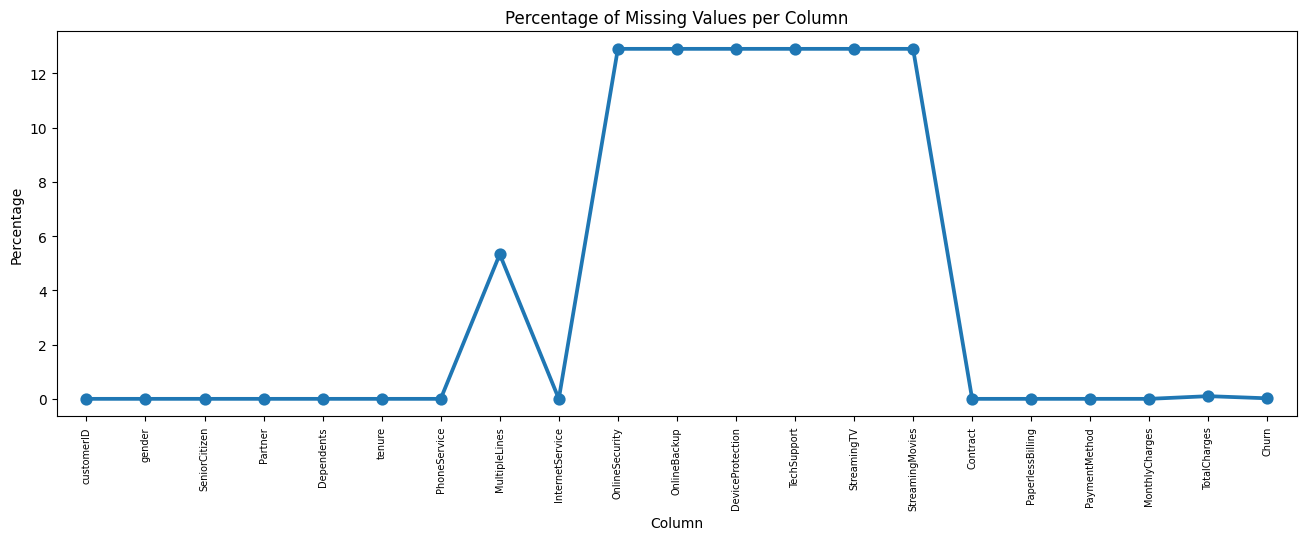

In [92]:
#pointplot of missing values
plt.figure(figsize=(16, 5))
ax = sns.pointplot(x='Column', y='Percentage', data=missing_df)
plt.xticks(rotation=90, fontsize=7)
plt.title('Percentage of Missing Values per Column')
plt.show()

In [93]:
# checking if there's any missing values
df_train.duplicated().any()

False

In [94]:
# overview of the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


As seen from the overview of the data above, 'SeniorCitizen' is supposed to be an object data type though it contains 0s and 1s.

'TotalCharges' is also not supposed to be an object, therefore the right data types will be assigned to these two columns.

In [95]:
# changing to appropriate data types
df_train['SeniorCitizen'] = df_train['SeniorCitizen'].astype(object)
df_train['TotalCharges'] = pd.to_numeric(df_train['TotalCharges'], errors='coerce') # for the sake of missing values that will considered as empty strings

In [96]:
# descriptive statistics of only the numerical columns
df_train.describe()

,tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5035.000000
mean,32.576641,65.090214,2302.062861
std,24.529807,30.068133,2269.483576
min,0.000000,18.400000,18.799999
25%,9.000000,35.775000,417.675003
50%,29.000000,70.550003,1401.150024
75%,56.000000,90.050003,3862.000000
max,72.000000,118.650002,8670.100000


**Insights from the descriptive statistics above**

Average:

- The average tenure is 32 months and 2 weeks.
- The average monthly charge for customers is 65 units.
- The average total charge for customers is 2,302 units.

Median(50th Percentile):

- The median tenure is 29 months.
- The median monthly charge for customers is 70.6 units.
- The median total charge for customers is 1,401 units.

75th percentile:

- 75% of customers have a tenure of less than 56 months.
- 90 units being the 75th percentile for monthly charges indicate that 25% of customers have monthly charges greater than 90 units.
- 3,862 units being the 75th percentile for total charges show that 25% of customers have total charges greater than 3,862 units.


In [97]:
# loop through columns in training data
for column in df_train.columns:

    #check if the column is not a numerical column
    if (df_train[column].dtype not in ['int64', 'float64']):

        # print out unique values in categorical columns
        print(f'column: {column}\nunique values: {df_train[column].unique()}')
        print(70 * '-')

    

column: customerID
unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------------------------------------
column: gender
unique values: ['Female' 'Male']
----------------------------------------------------------------------
column: SeniorCitizen
unique values: [0 1]
----------------------------------------------------------------------
column: Partner
unique values: [True False 'No' 'Yes']
----------------------------------------------------------------------
column: Dependents
unique values: [False True 'No' 'Yes']
----------------------------------------------------------------------
column: PhoneService
unique values: [False True 'Yes' 'No']
----------------------------------------------------------------------
column: MultipleLines
unique values: [None False True 'No' 'No phone service' 'Yes']
----------------------------------------------------------------------
column: InternetService
unique valu

As seen from the output above, a lot of the categorical columns contain values boolean values(True, False) and 'Yes' and 'No' values which are the same meaning as the boolean values but are viewed differently in python. To solve this issue, we either change the boolean values to 'Yes' and 'No', or the other way round.

In [98]:
   
columns_to_change = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'Churn', 'PaperlessBilling']
for column in columns_to_change:    
    df_train[column].replace({True: 'Yes', False: 'No', 'No internet service': 'No', 'No phone service': 'No', None: np.nan}, inplace=True)


In [99]:
# check the unique values in these columns to confirm
# loop through columns in training data
for column in df_train.columns:

    #check if the column is not a numerical column
    if (df_train[column].dtype not in ['int64', 'float64']):

        # print out unique values in categorical columns
        print(f'column: {column}\nunique values: {df_train[column].unique()}')
        print(70 * '-')

column: customerID
unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
----------------------------------------------------------------------
column: gender
unique values: ['Female' 'Male']
----------------------------------------------------------------------
column: SeniorCitizen
unique values: [0 1]
----------------------------------------------------------------------
column: Partner
unique values: ['Yes' 'No']
----------------------------------------------------------------------
column: Dependents
unique values: ['No' 'Yes']
----------------------------------------------------------------------
column: PhoneService
unique values: ['No' 'Yes']
----------------------------------------------------------------------
column: MultipleLines
unique values: [nan 'No' 'Yes']
----------------------------------------------------------------------
column: InternetService
unique values: ['DSL' 'Fiber optic' 'No']
---------------------------------

Changes has reflected successfully

Now I go ahead and add a new column called 'tenure_group' where customers have been categorized into tenure ranges in years so I can understand the relationship between tenure groups and churn status, and not just the lentgh of tenure and churn status.

In [100]:
# First we check for maximum tenure which is we are not going to exceed
df_train['tenure'].max()

72

In [101]:
# create a function to create year ranges (in months)
def to_years(x):
    if x <= 12:
        return '0-1 year'
    elif x > 12 and x <= 24:
        return '1-2 years'
    elif x > 24 and x <= 36:
        return '2-3 years'
    elif x > 36 and x <= 48:
        return '3-4 years'
    elif x > 48 and x <= 60:
        return '4-5 years'
    elif x > 60:
        return '5+ years'


In [102]:
#add new column for tenure groups
df_train['tenure_group'] = df_train['tenure'].apply(to_years)

### **Univariate Analysis**

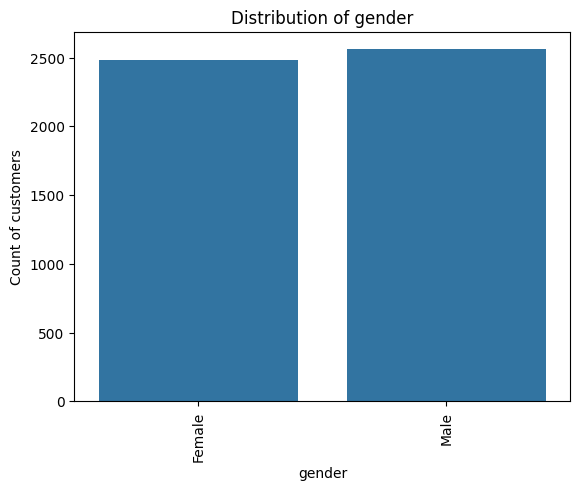

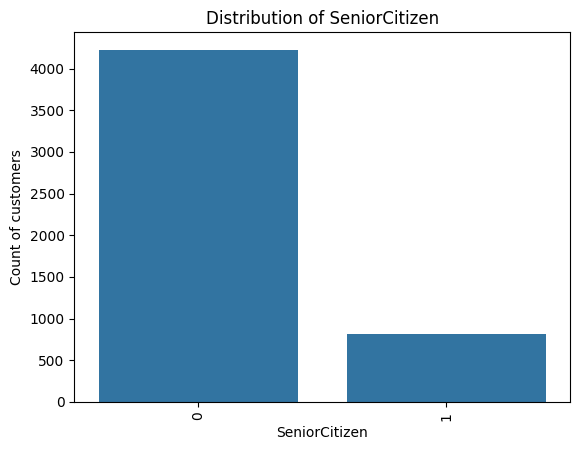

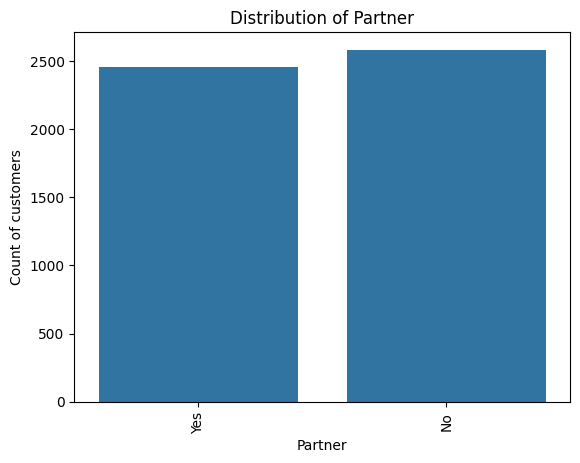

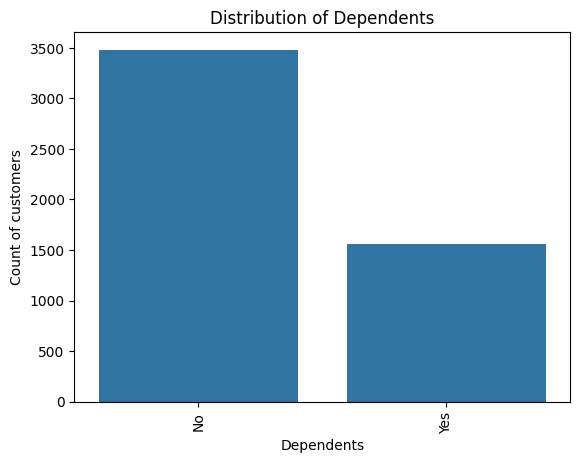

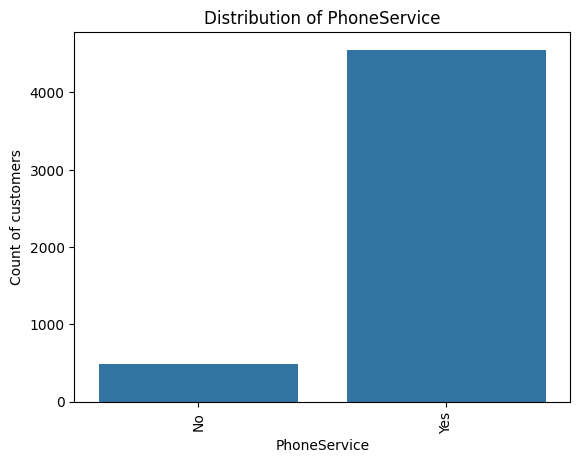

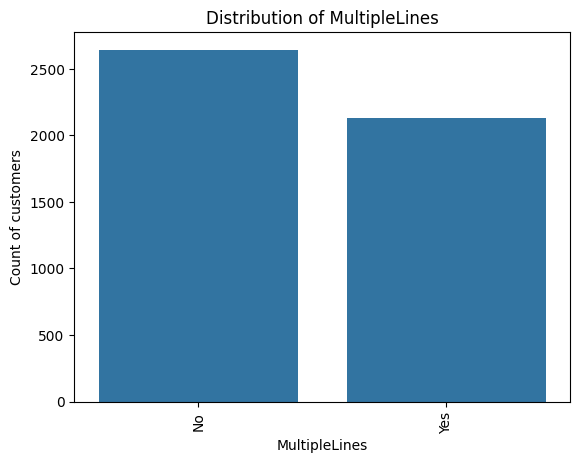

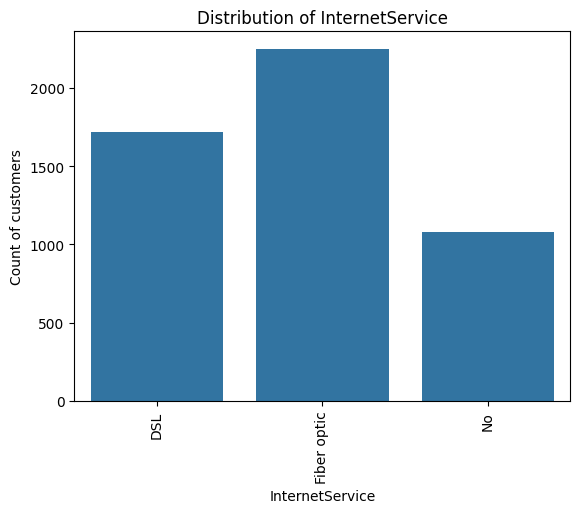

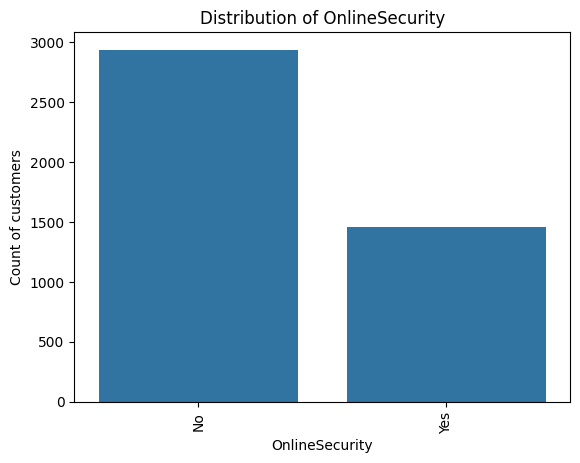

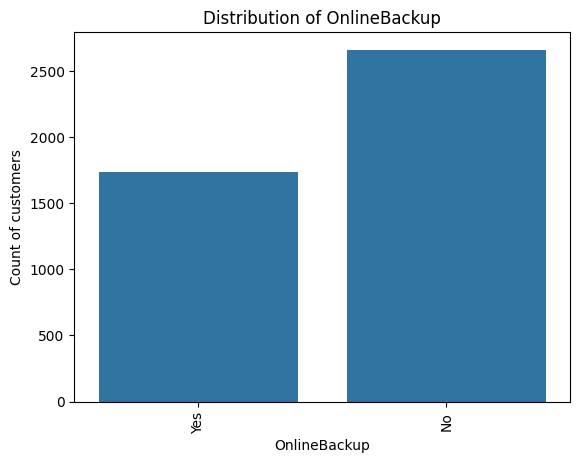

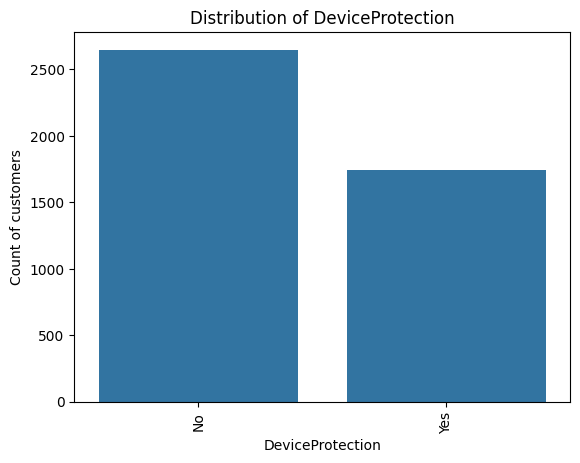

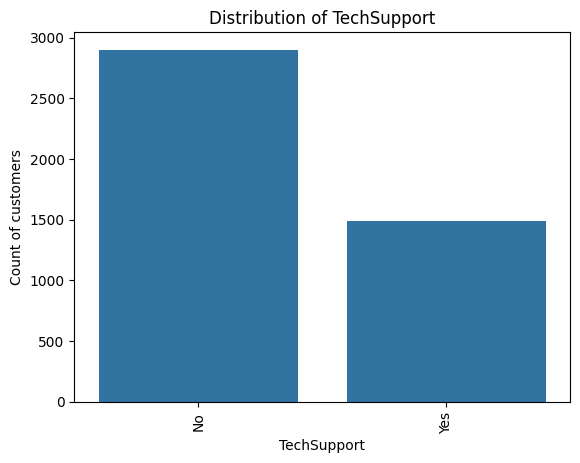

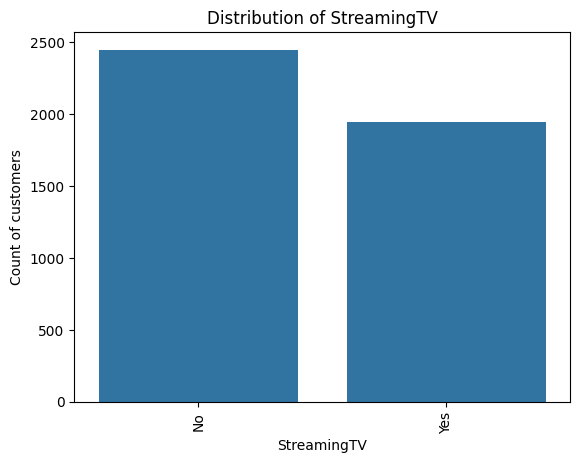

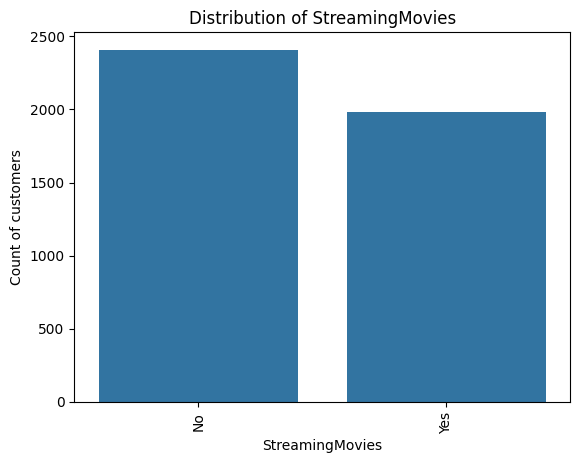

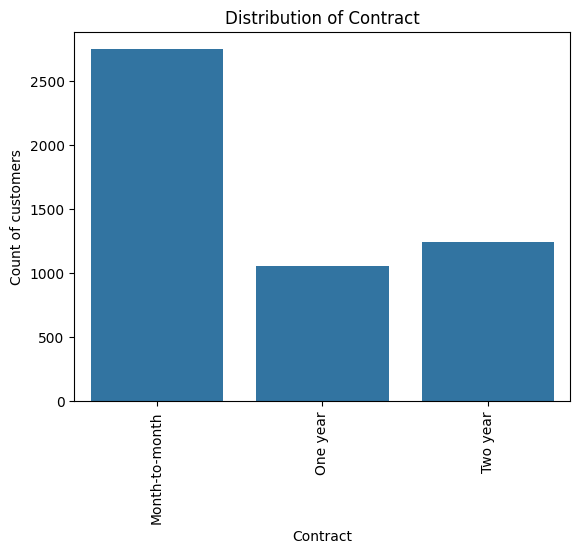

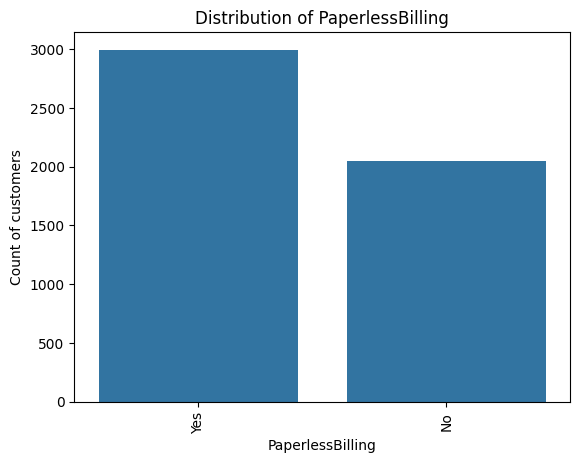

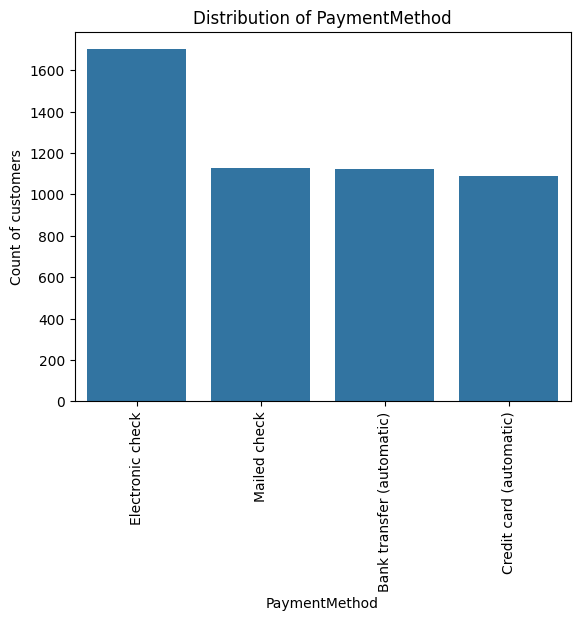

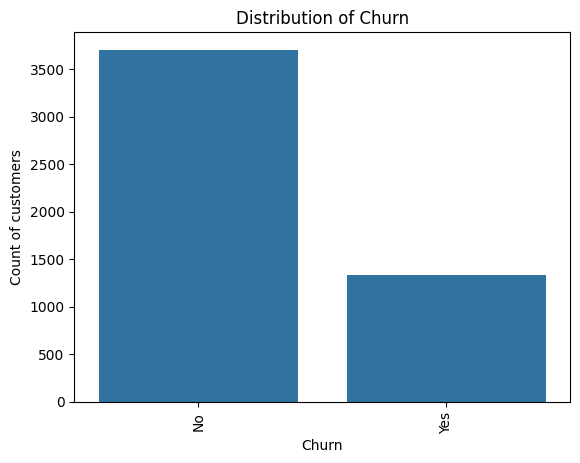

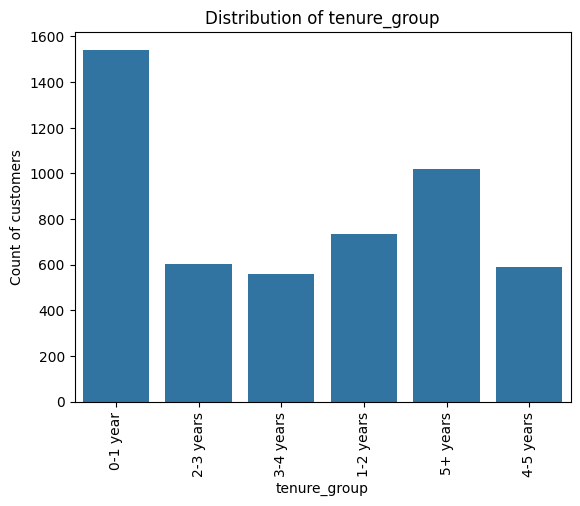

In [103]:
# Distribution of the categorical columns
for i, predictor in enumerate(df_train.drop(columns=['TotalCharges', 'MonthlyCharges', 'customerID', 'tenure'])):
    plt.figure(i)
    sns.countplot(data=df_train, x=predictor)
    plt.xticks(rotation=90)
    plt.title(f'Distribution of {predictor}')
    plt.xlabel(f'{predictor}')
    plt.ylabel('Count of customers')
    plt.show()

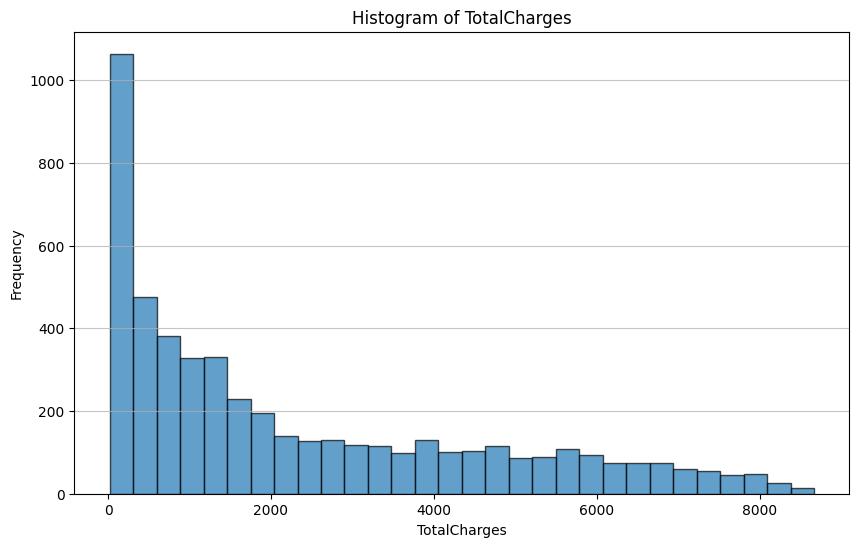

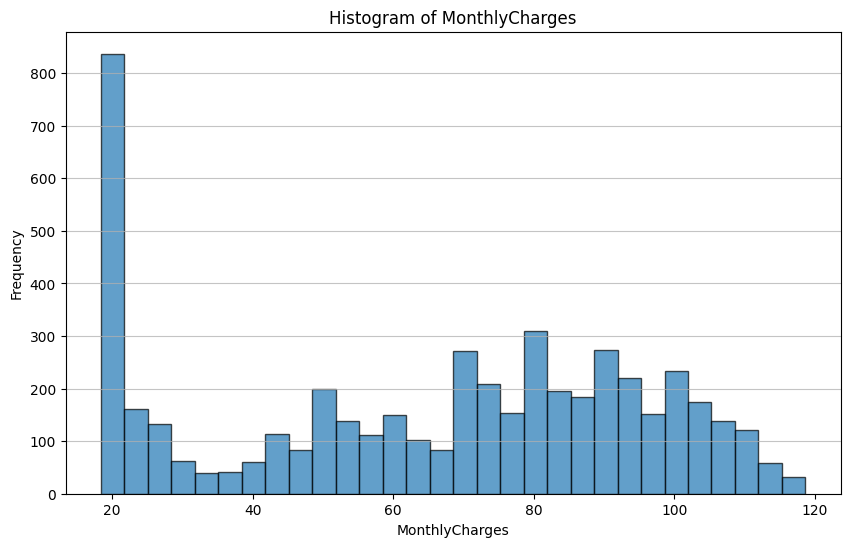

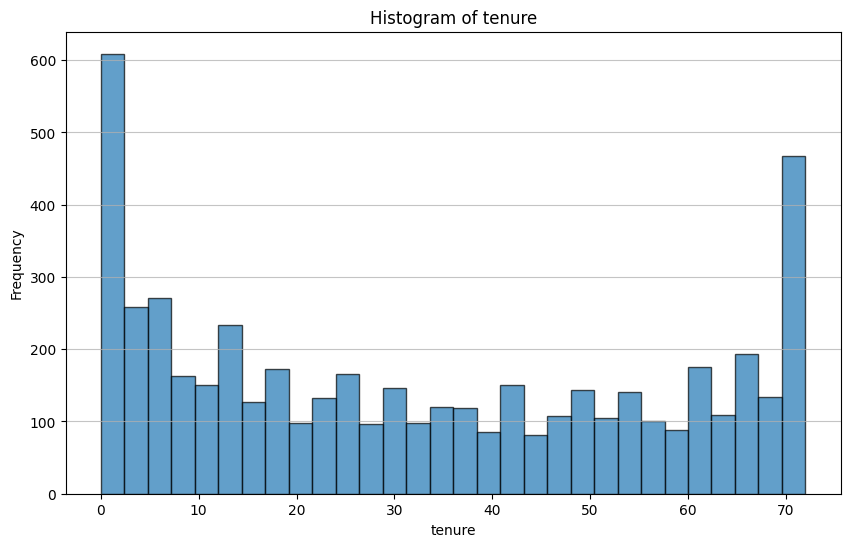

In [104]:
# Distribution of the Numerical columns
# Iterate through each numerical column and plot a histogram
for column in ['TotalCharges', 'MonthlyCharges', 'tenure']:
    plt.figure(figsize=(10, 6))
    plt.hist(df_train[column].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

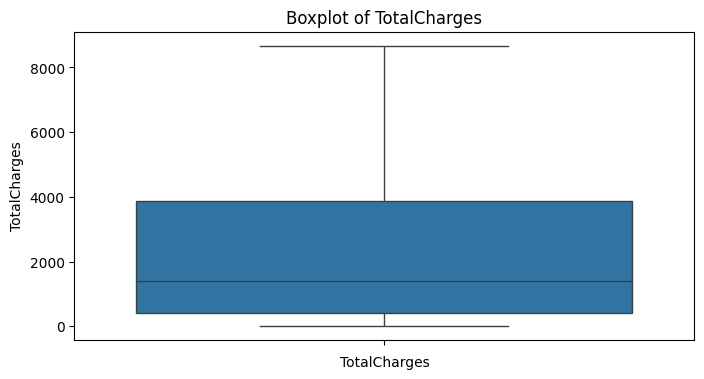

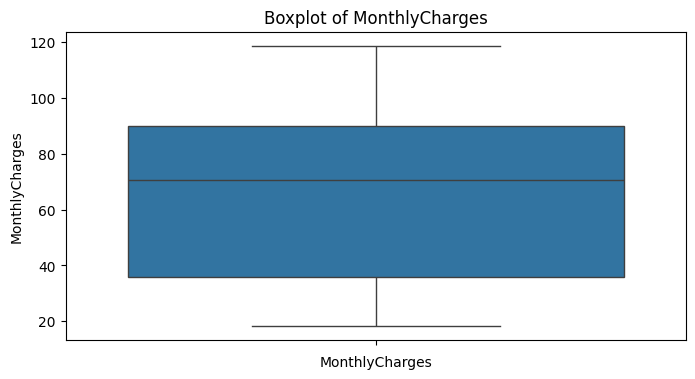

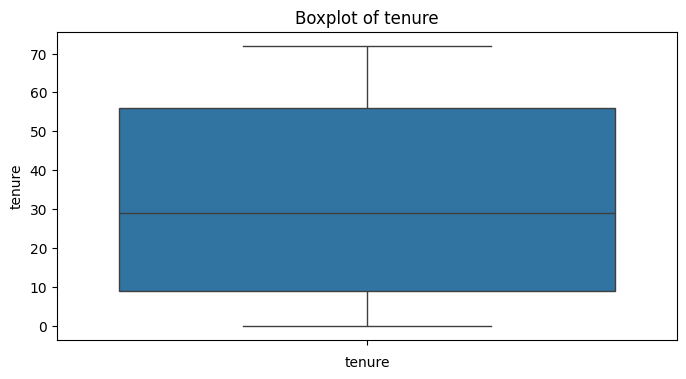

In [105]:
# boxplot of the Numerical columns
# Iterate through each numerical column and plot a boxplot
for column in ['TotalCharges', 'MonthlyCharges', 'tenure']:
    plt.figure(figsize=(8,4))
    sns.boxplot(df_train[column].dropna())
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

#### Key Insights from the Univariate Analysis

- Male customers are a little bit more than female customers
- Looking at the the distribution for the 'SeniorCitizen' column, it is obvious number of senior citizens are very small as compared to non-senior citizens (Youthful costomers).
- The are more non-churners than churners, with the distribution plot showing that non-churners are more than twice the number of churners. Since this is our target variable, the distribution shows are imbalance in the classes.
- Electronic check is the most used payment method for customers.
- The histogram for Total charges shows a right skew
- The histogram and boxplots of the numerical columns shows no outliers.
- Customers in the tenure group of 0 to 1 year are more than customers in any other tenure group.

### **Bivariate Analysis**

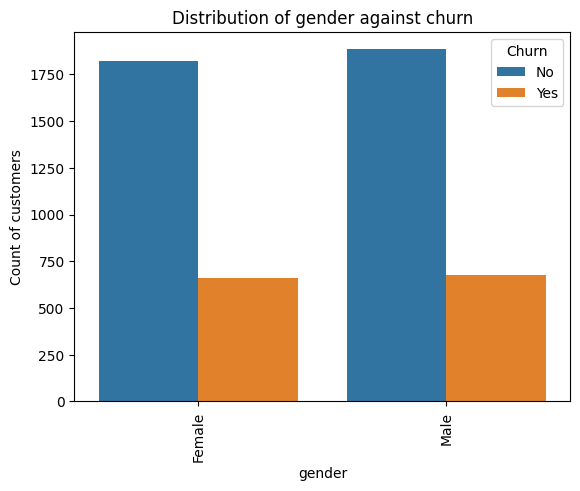

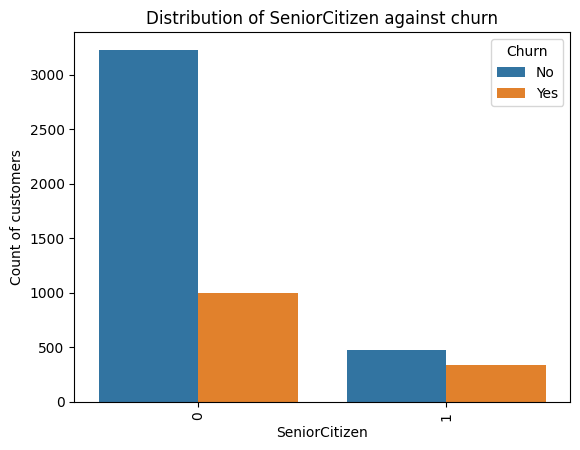

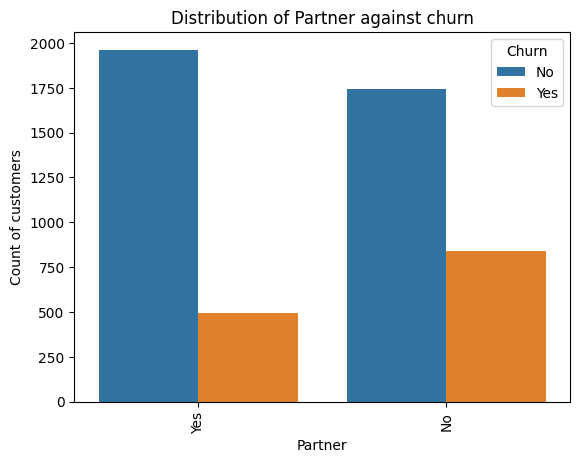

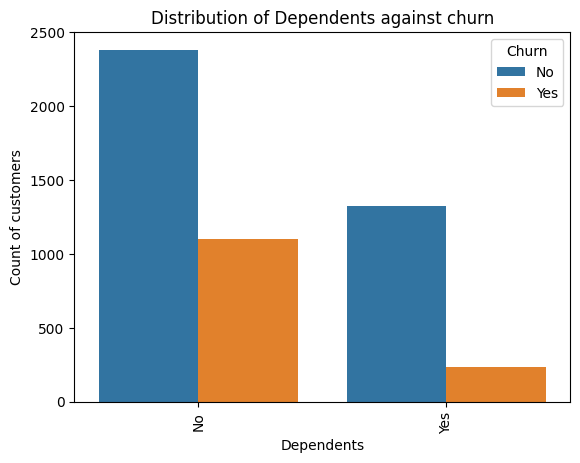

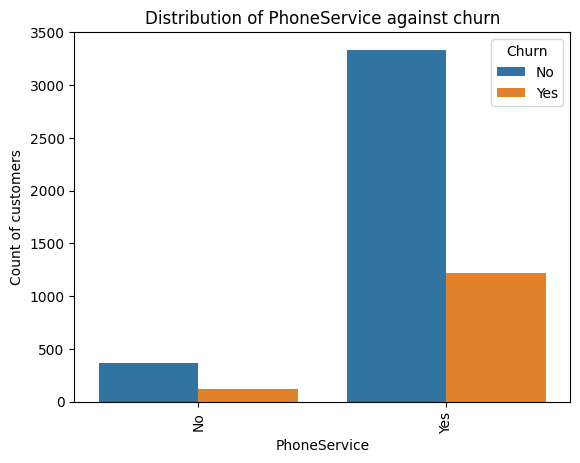

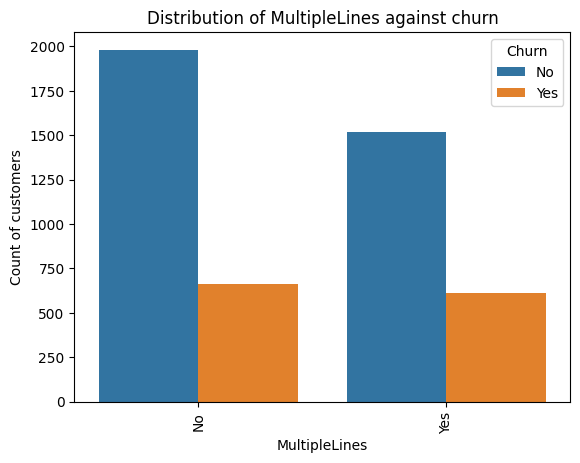

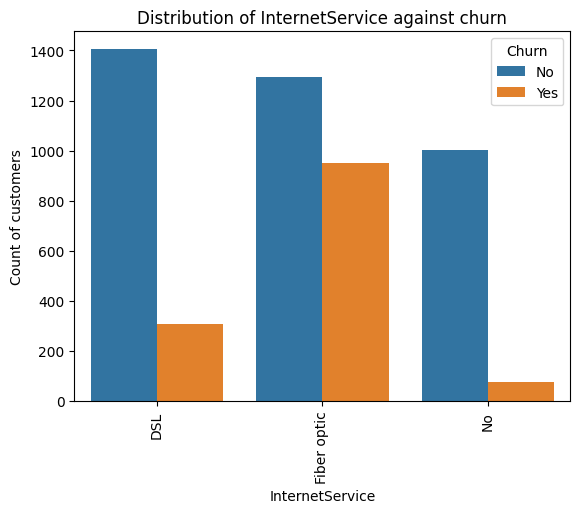

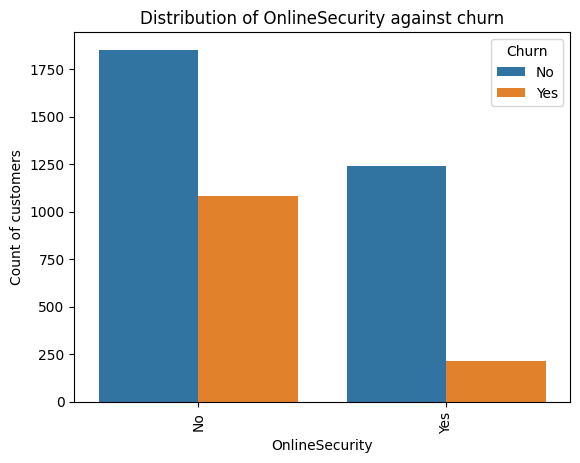

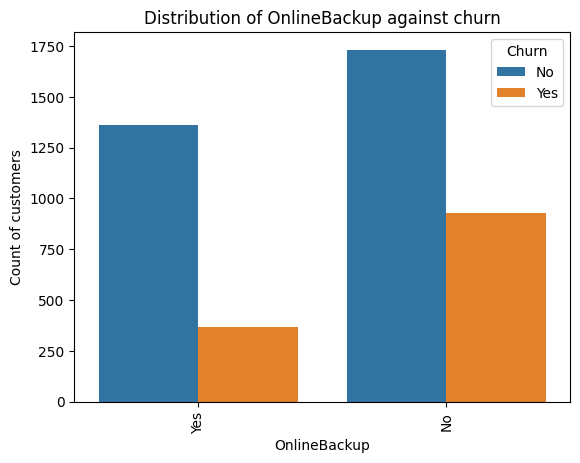

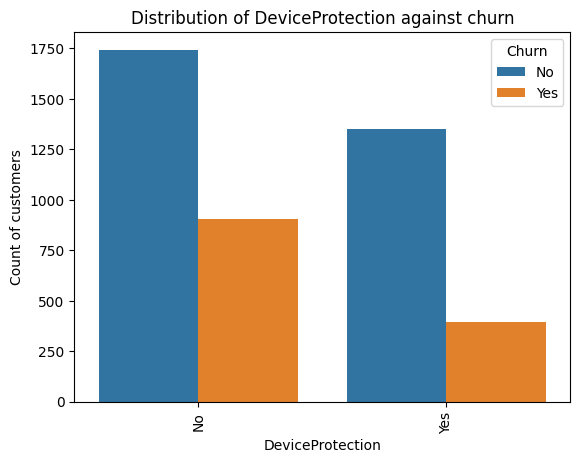

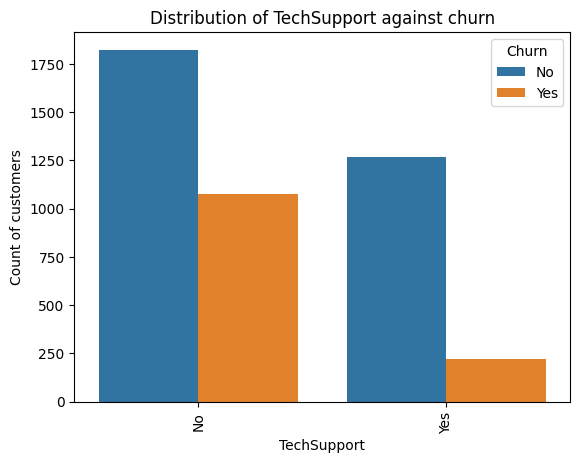

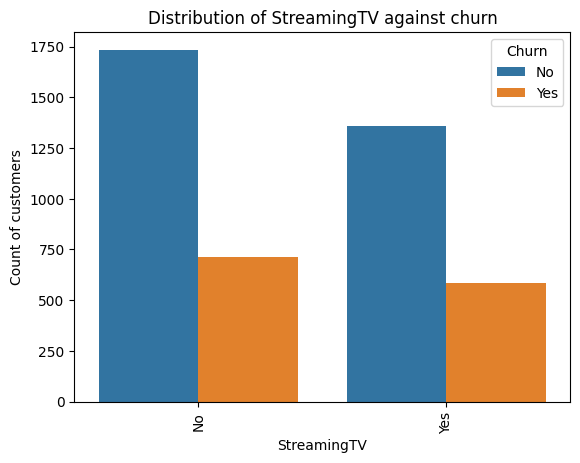

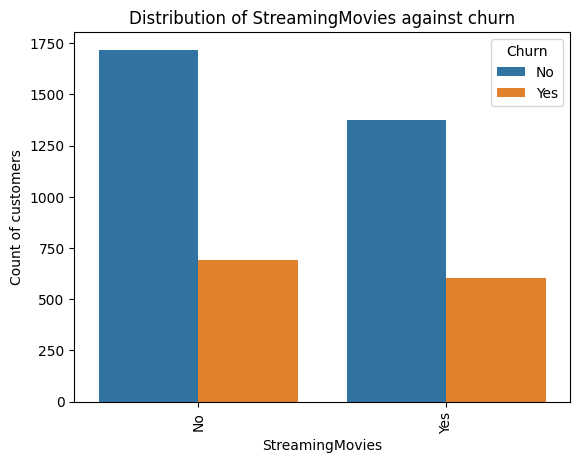

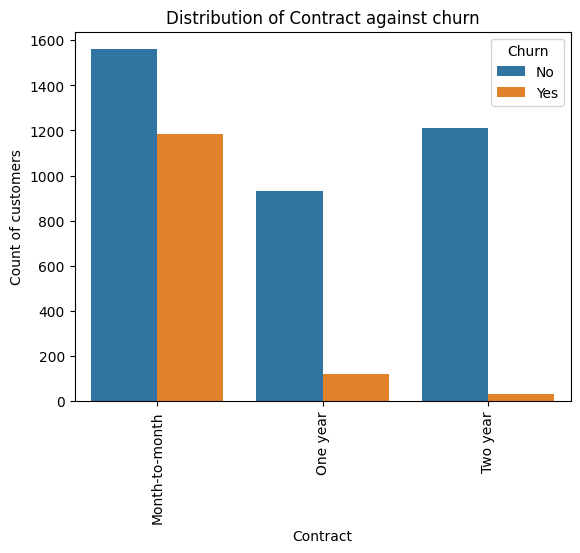

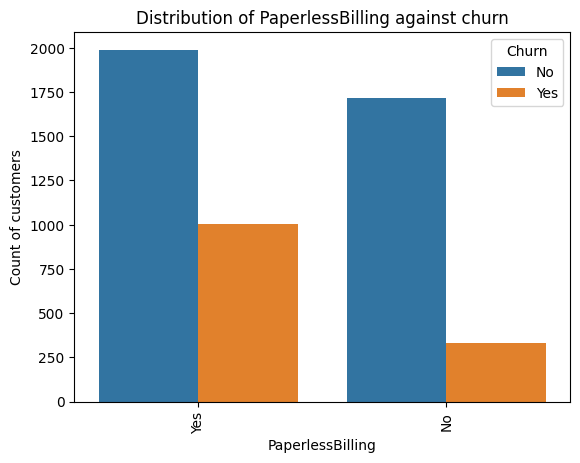

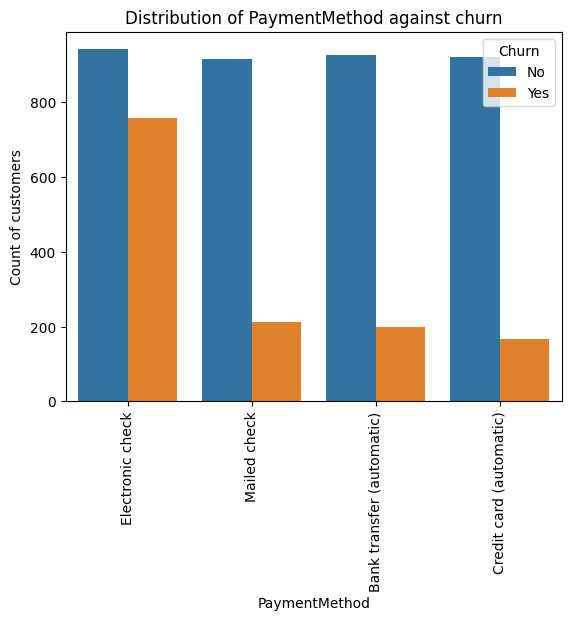

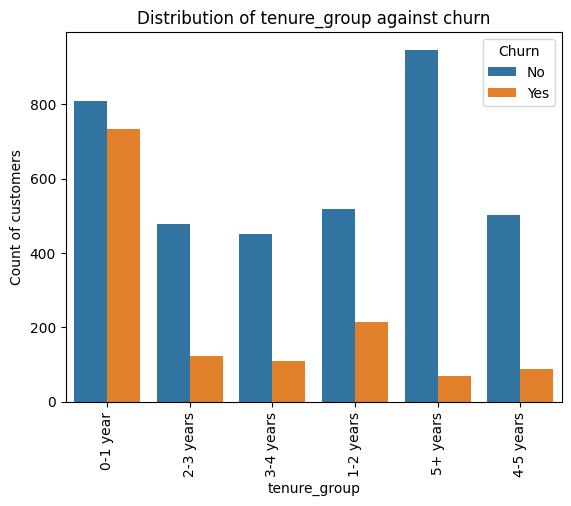

In [106]:
# Distributions of the Categorical columns against churn 
for i, predictor in enumerate(df_train.drop(columns=['Churn','TotalCharges', 'MonthlyCharges', 'tenure', 'customerID'])):
    plt.figure(i)
    sns.countplot(data=df_train, x=predictor, hue='Churn')
    plt.xticks(rotation=90)
    plt.title(f'Distribution of {predictor} against churn')
    plt.xlabel(f'{predictor}')
    plt.ylabel('Count of customers')
    plt.show()

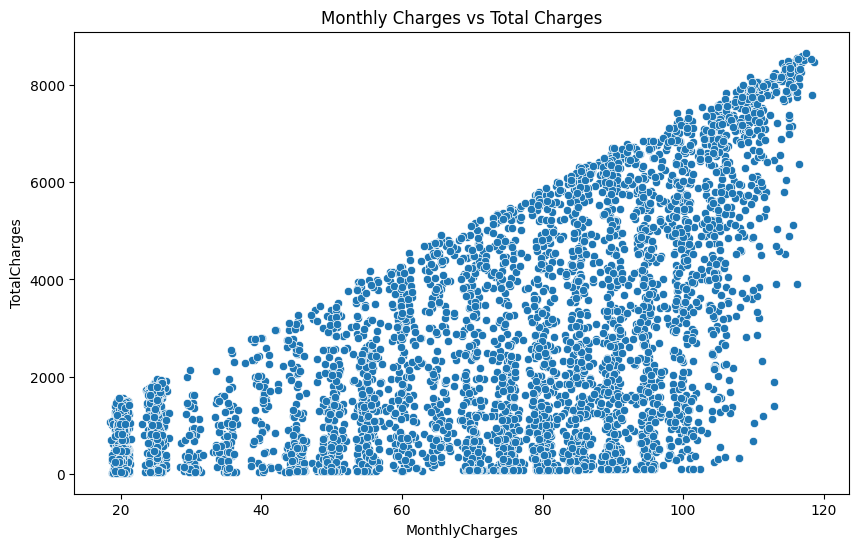

In [107]:
# Bivariate Analysis: Numerical vs Numerical (MonthlyCharges vs TotalCharges)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=df_train)
plt.title('Monthly Charges vs Total Charges')
plt.show()

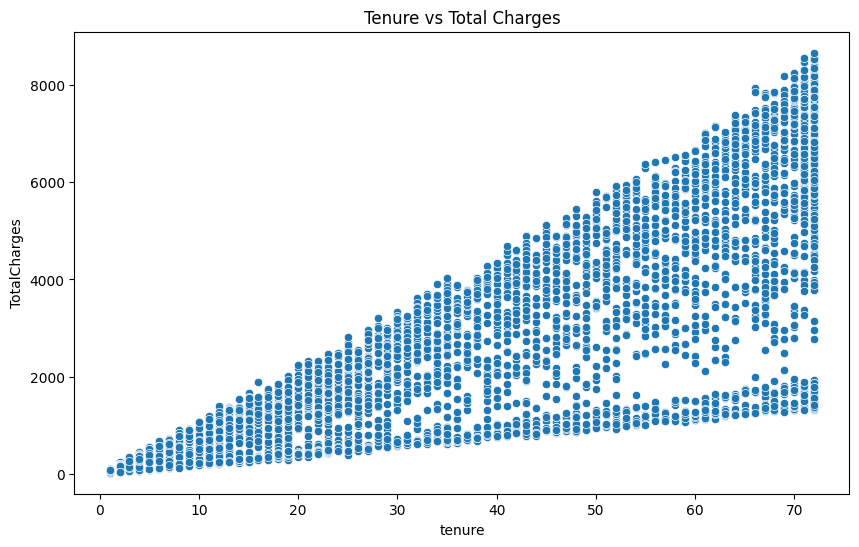

In [108]:
# Bivariate Analysis: Numerical vs Numerical (tenure vs TotalCharges)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tenure', y='TotalCharges', data=df_train)
plt.title('Tenure vs Total Charges')
plt.show()

### **Multivariate Analysis**

Correlation Matrix:
                 MonthlyCharges  TotalCharges    tenure
MonthlyCharges        1.000000      0.647007  0.240645
TotalCharges          0.647007      1.000000  0.826264
tenure                0.240645      0.826264  1.000000


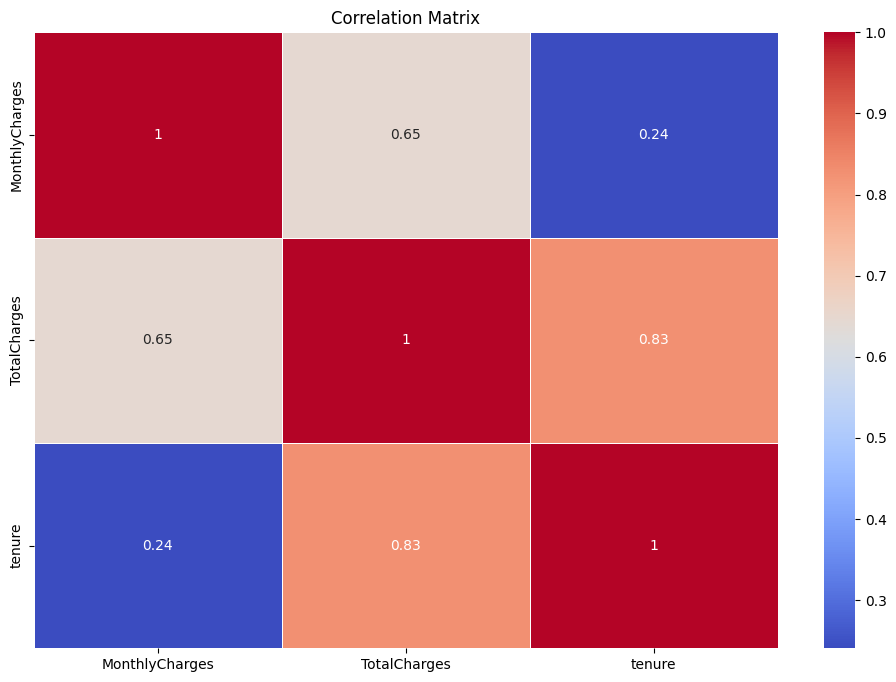

In [109]:
# Calculate correlation matrix
numerical_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
correlation_matrix = df_train[numerical_cols].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<Figure size 1500x1000 with 0 Axes>

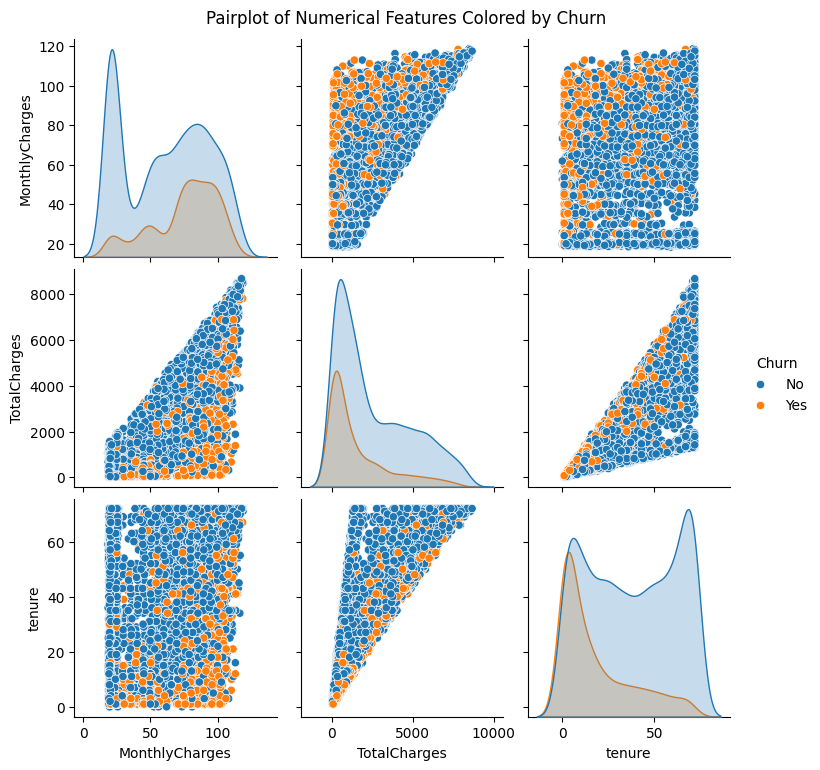

In [110]:
# Multivariate Analysis: Pairplot
plt.figure(figsize=(15, 10))
sns.pairplot(df_train[['MonthlyCharges', 'TotalCharges', 'Churn', 'tenure']], hue='Churn')
plt.suptitle('Pairplot of Numerical Features Colored by Churn', y=1.02)
plt.show()

<Figure size 1500x1000 with 0 Axes>

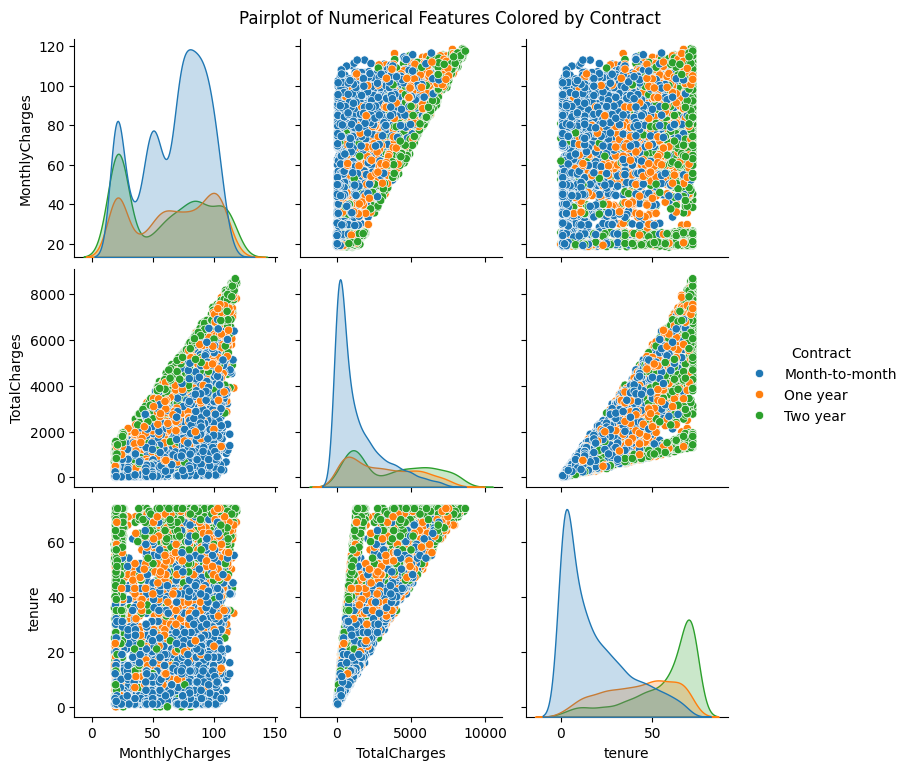

In [111]:
# Multivariate Analysis: Pairplot with categorical feature 'Contract'
plt.figure(figsize=(15, 10))
sns.pairplot(df_train[['MonthlyCharges', 'TotalCharges', 'Contract', 'tenure']], hue='Contract')
plt.suptitle('Pairplot of Numerical Features Colored by Contract', y=1.02)
plt.show()

<Figure size 1500x1000 with 0 Axes>

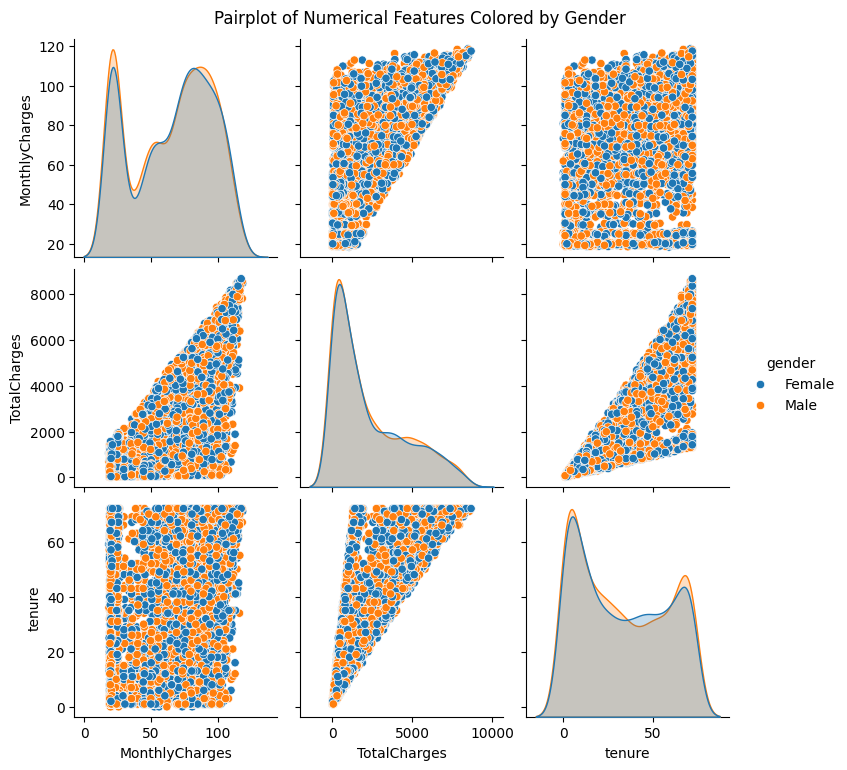

In [112]:
# Multivariate Analysis: Pairplot with categorical feature 'Gender'
plt.figure(figsize=(15, 10))
sns.pairplot(df_train[['MonthlyCharges', 'TotalCharges', 'gender', 'tenure']], hue='gender')
plt.suptitle('Pairplot of Numerical Features Colored by Gender', y=1.02)
plt.show()

#### Key Insights from Bivariate Analysis and Multivariate Analysis

- More than half of senior citizens are churning.
- Customers without partners churn more than customers with partners.
- Customers without internet service are not churning much.
- Customers with month-to-month contacts are churning a lot more than customers with one-year contract and two-year contracts.
- There's a strong positive linear relationship between length of tenure and Total charges, with an impressive correlation coefficient of 0.83
- A lot of Customers with month-to-month contacts have tenures below 50 months, as compared to customers with one-year contract and two-year contracts, who have a tenures above 50 months.
- Customers with month-to-month contacts have higher monthly charges than customers with one-year contract and two-year contracts.

### **Hypothesis Testing**

In this section, we will examine our hypothesis statistically to determine if there's enough/significant evidence to back them.


- Hypothesis 1: Customers with longer tenure are less likely to churn.

Null Hypothesis (H0): There is no significant association between tenure group and churn rate.

Alternative Hypothesis(H1): There is an assocation between tenure group and churn rate.
​

In [113]:

# Create a contingency table
contingency_table = pd.crosstab(df_train['tenure_group'], df_train['Churn'])
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test for independence
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")

# Interpret the result
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant association between tenure group and churn rate.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between tenure group and churn rate.")



Contingency Table:
Churn          No  Yes
tenure_group          
0-1 year      809  733
1-2 years     517  215
2-3 years     479  124
3-4 years     451  108
4-5 years     503   87
5+ years      947   69
Chi-Square Statistic: 623.6282758746469
P-value: 1.5853878918829318e-132
Reject the null hypothesis: There is a significant association between tenure group and churn rate.


At a significance level of 5%, there is enough evidence to conclude that customers with longer tenures are less likely to churn.

- Hypothesis 2: Customers with longer contracts are less likely to churn.

Null Hypothesis (H0): There is no significant association between contract type and churn rate.

Alternative Hypothesis(H1): There is an assocation between contract type and churn rate.

In [114]:
# Create a contingency table
contingency_table = pd.crosstab(df_train['Contract'], df_train['Churn'])
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test for independence
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")

# Interpret the result
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant association between contract type and churn rate.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between contract and churn rate.")

Contingency Table:
Churn             No   Yes
Contract                  
Month-to-month  1560  1184
One year         933   122
Two year        1213    30
Chi-Square Statistic: 881.6208905118242
P-value: 3.61789584641233e-192
Reject the null hypothesis: There is a significant association between contract type and churn rate.


At a significance level of 5%, there is enough evidence to conclude that customers with longer contracts are less likely to churn.

Now we go ahead to answer our bsuiness question.

### **Answering Business Questions**

1. What are the main reasons behind customer churn?

   - Understanding the primary factors contributing to churn can help in addressing the root causes and developing effective retention strategies.

To test the whether there is any association between customer churn and the categorical features, we are going to use the chi-square test which test for association.

The output will be a list of features along with their respective p-values from the chi-square test. Here's what the results mean:

p-value: The p-value helps determine whether there is a statistically significant association between the categorical feature and the Churn variable.

Low p-value (< 0.05): Indicates that there is a significant association between the feature and Churn.

High p-value (≥ 0.05): Indicates that there is no significant association between the feature and Churn.

In [115]:
# Identify categorical features
categorical_features = df_train.select_dtypes(include=['object']).columns

# Initialize a list to store features that affect churn
significant_features_chi2 = []

# Initialize a dictionary to store p-values of all features
feature_p_values = {}

# Loop through each categorical feature
for feature in categorical_features:
    if feature != 'Churn':
        
        contingency_table = pd.crosstab(df_train[feature], df_train['Churn'])
        
        
        chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
        
        # Store the p-value in the dictionary
        feature_p_values[feature] = p_val
        
        if p_val < 0.05:
            significant_features_chi2.append(feature)

# Print the p-values for all features
print("P-values for all features:")
for feature, p_val in feature_p_values.items():
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"Feature: {feature}, p-value: {p_val:.6f} ({significance})")

# Print the list of significant features
print("\nSignificant features affecting churn:")
print(significant_features_chi2)

P-values for all features:
Feature: customerID, p-value: 0.493379 (Not Significant)
Feature: gender, p-value: 0.883080 (Not Significant)
Feature: SeniorCitizen, p-value: 0.000000 (Significant)
Feature: Partner, p-value: 0.000000 (Significant)
Feature: Dependents, p-value: 0.000000 (Significant)
Feature: PhoneService, p-value: 0.327932 (Not Significant)
Feature: MultipleLines, p-value: 0.006172 (Significant)
Feature: InternetService, p-value: 0.000000 (Significant)
Feature: OnlineSecurity, p-value: 0.000000 (Significant)
Feature: OnlineBackup, p-value: 0.000000 (Significant)
Feature: DeviceProtection, p-value: 0.000000 (Significant)
Feature: TechSupport, p-value: 0.000000 (Significant)
Feature: StreamingTV, p-value: 0.493284 (Not Significant)
Feature: StreamingMovies, p-value: 0.175947 (Not Significant)
Feature: Contract, p-value: 0.000000 (Significant)
Feature: PaperlessBilling, p-value: 0.000000 (Significant)
Feature: PaymentMethod, p-value: 0.000000 (Significant)
Feature: tenure_grou

2. Which customer demographics (e.g., age, gender, marital status) are more likely to churn?

   - Identifying specific demographic groups that are more prone to churn can help tailor marketing and retention efforts to those segments.

With this, we will go head to calculate the churn rate of for customers in our demographical features like age(SeniorCitizen), marital status (Partner), faimly(Dependents), and their gender.

In [116]:
# get the data for only churners
churners = df_train.loc[(df_train['Churn'] == 'Yes')]
churners

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes,0-1 year
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes,0-1 year
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes,0-1 year
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800003,3046.050049,Yes,2-3 years
13,0280-XJGEX,Male,0,No,No,49,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.699997,5036.299805,Yes,4-5 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021,1699-HPSBG,Male,0,No,No,12,Yes,No,DSL,No,...,Yes,Yes,No,One year,Yes,Electronic check,59.800000,727.800000,Yes,0-1 year
5026,8775-CEBBJ,Female,0,No,No,9,Yes,No,DSL,No,...,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.200000,403.350000,Yes,0-1 year
5032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,75.750000,75.750000,Yes,0-1 year
5034,0639-TSIQW,Female,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,No,Yes,No,Month-to-month,Yes,Credit card (automatic),102.950000,6886.250000,Yes,5+ years


In [117]:
# separate churners into their demographics
age_churners = churners['SeniorCitizen']
family_churners = churners['Dependents']
married_churners = churners['Partner']
gender_churners = churners['gender']

total_customers = df_train.shape[0]

In [118]:
# calculating churn rates for customers demographics

age_churn_rate = age_churners.value_counts()/total_customers
family_churn_rate = family_churners.value_counts()/total_customers
married_churn_rate = married_churners.value_counts()/total_customers
gender_churn_rate = gender_churners.value_counts()/total_customers

print(age_churn_rate)
print(family_churn_rate)
print(married_churn_rate)
print(gender_churn_rate)


SeniorCitizen
0    0.197501
1    0.067420
Name: count, dtype: float64
Dependents
No     0.217926
Yes    0.046996
Name: count, dtype: float64
Partner
No     0.166964
Yes    0.097958
Name: count, dtype: float64
gender
Male      0.133849
Female    0.131073
Name: count, dtype: float64


As seen from churn rates above, among all the customer demopgraphics, people with no dependents (family or anyone that rely on them for financial support) have the highest churn rate (0.22).

3. How does the length of the customer's tenure impact their likelihood to churn?

   - Analyzing the relationship between tenure and churn can reveal whether long-term customers are more loyal and what measures can be taken to extend customer tenure.

In [119]:
# Create a contingency table
contingency_table = pd.crosstab(df_train['tenure_group'], df_train['Churn'])
# Calculate the churn rate for each tenure group
contingency_table['Churn Rate'] = contingency_table['Yes'] / (contingency_table['Yes'] + contingency_table['No'])

# Print the contingency table with churn rate
print("\nContingency Table with Churn Rate:")
print(contingency_table)


Contingency Table with Churn Rate:
Churn          No  Yes  Churn Rate
tenure_group                      
0-1 year      809  733    0.475357
1-2 years     517  215    0.293716
2-3 years     479  124    0.205638
3-4 years     451  108    0.193202
4-5 years     503   87    0.147458
5+ years      947   69    0.067913


Churn rate is inversely proportional to the length of tenure as seen, as tenure length increases, churn rate decrease. We can conclude that customers who has stayed long with the telco company are less likely to churn as compared to customers who have not really been with the telco company for long. This conclusion has already been proven statistically when we tested if tenure length has any influence on churn rate.

4. What role do service issues (e.g., technical support, service outages) play in customer churn?

   - Assessing the impact of service quality on churn can guide improvements in customer support and service reliability.



In [120]:
# Create a contingency table
contingency_table = pd.crosstab(df_train['TechSupport'], df_train['Churn'])
# Calculate the churn rate for each tenure group
contingency_table['Churn Rate'] = contingency_table['Yes'] / (contingency_table['Yes'] + contingency_table['No'])

# Print the contingency table with churn rate
print("\nContingency Table with Churn Rate:")
print(contingency_table)


Contingency Table with Churn Rate:
Churn          No   Yes  Churn Rate
TechSupport                        
No           1824  1076    0.371034
Yes          1270   221    0.148223


Customers with no Technical Support have higher churn rate (0.37) as compared to customers with Technical Support(0.15). Customers without technical support might be churning more due dissatisfaction with service provider when they have technical issues.

## **Data Preparation and Modelling**

### Split dataset into training and evaluation set

In [121]:
df_train.drop(columns=['tenure_group'], axis = True, inplace=True)

In [122]:
# Fill missing numerical values with the mean of the column
for col in df_train.select_dtypes(include=['float64', 'int64']).columns:
    df_train[col].fillna(df_train[col].mean(), inplace=True)

# Fill missing categorical values with the most frequent value of the column
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col].fillna(df_train[col].value_counts().idxmax(), inplace=True)

In [123]:
# Create X and y split for the dataset
X = df_train.drop(columns='Churn', axis=1)
y = df_train['Churn']
# Split the dataset into training and evaluation set
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

### Pipelines

Creating custom transformers for columns in the dataset

In [124]:
# Create a class to deal with dropping Customer ID from the dataset
class columnDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop the specified column
        return X.drop('customerID', axis=1)
    
    def get_feature_names_out(self, input_features=None):
        # If input_features is None or not provided, return None
        if input_features is None:
            return None
        # Return feature names after dropping the specified column
        return [feature for feature in input_features if feature != 'customerID']


# Create a class to deal with the inconsistencies in the totalCharges column and convert it into a float
class TotalCharges_cleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Replace empty string with NA
        X['TotalCharges'].replace(' ', np.nan, inplace=True)

        # Convert the values in the Totalcharges column to a float
        X['TotalCharges'] = X['TotalCharges'].transform(lambda x: float(x))
        return X
    # Since this transformer doesn't remove or alter features, return the input features
    def get_feature_names_out(self, input_features=None):
        return input_features

Create numerical, categorical, full pipeline, and label encoders for machine learning algorithm.

In [125]:
# Select the categorical and numerical columns in the dataset
num_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_columns = ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


# Create a categorical pipeline
cat_pipeline = Pipeline([
        ('column_dropper', columnDropper()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No')),
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# Create a numerical pipeline
num_pipeline = Pipeline([
        ('total_charges_cleaner', TotalCharges_cleaner()),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('pt_transform', PowerTransformer()),
        ('scaling', StandardScaler()),
])

# Create a full pipeline which contains the categorial and numerical pipeline
full_pipeline = ColumnTransformer([    
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, cat_columns),
])

# Encode the outcome column
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_eval_encoded = label_encoder.transform(y_eval)

## Random Classifier Pipeline

In [126]:
randomForest_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', RandomForestClassifier(random_state=0))
])

randomForest_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',
                                                                   columnDropper())...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen'])])),
                ('classifier', RandomForestClassifier(random_state=0))])

In [127]:
# Get y predict values using random forest pipeline
rfc_y_pred = randomForest_pipeline.predict(X_eval)

# Get classification report for true and predicted values
rfc_report = classification_report(y_eval_encoded, rfc_y_pred)

# Define model predictions for the model and true labels
rfc_pred_proba = randomForest_pipeline.predict_proba(X_eval)[:,1]

# Calculate FPR and TPR for the model
rfc_fpr, rfc_tpr, _ = roc_curve(y_eval_encoded, rfc_pred_proba)

# Calculate AUC for the model
rfc_auc_score = auc(rfc_fpr, rfc_tpr)

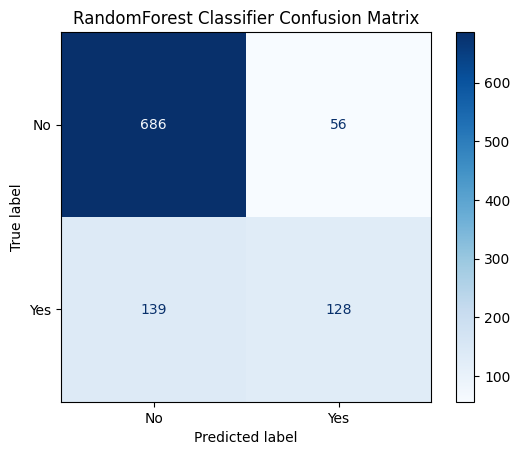

In [128]:
# Get confusion matrix values and display using confusion matrix display
rfc_cnf_matrix = confusion_matrix(y_eval_encoded, rfc_y_pred)
disp = ConfusionMatrixDisplay(rfc_cnf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('RandomForest Classifier Confusion Matrix');

### Observation

The model is able to correctly predict 676 customers that will not churn and 131 customers that will churn. That is a total of 807 correct predictions while wrongly predicting 202 instances.

## Decision Tree Pipeline

In [129]:
decisionTree_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=0))
])

decisionTree_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',
                                                                   columnDropper())...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen'])])),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [130]:
# Get y predict values using decision tree pipeline
dtc_y_pred = decisionTree_pipeline.predict(X_eval)

# Get classification report for true and predicted values
dtc_report = classification_report(y_eval_encoded, dtc_y_pred)

# Define model predictions for the model and true labels
dtc_pred_proba = decisionTree_pipeline.predict_proba(X_eval)[:,1]

# Calculate FPR and TPR for the model
dtc_fpr, dtc_tpr, _ = roc_curve(y_eval_encoded, dtc_pred_proba)

# Calculate AUC for the model
dtc_auc_score = auc(dtc_fpr, dtc_tpr)

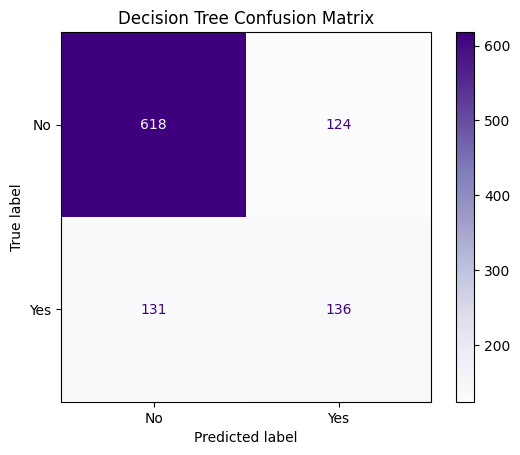

In [131]:
# Get confusion matrix values and display using confusion matrix display
dtc_cnf_matrix = confusion_matrix(y_eval_encoded, dtc_y_pred)
disp = ConfusionMatrixDisplay(dtc_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('Decision Tree Confusion Matrix');

### Observation

The model correctly predicts 626 non-churn instances and 129 churn instances, , making a total of 755 correct predictions and 254 wrong predictions.

### Gradient Boosting Classifier Pipeline

In [132]:
gradientBoosting_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', GradientBoostingClassifier(random_state=0))
])

gradientBoosting_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',
                                                                   columnDropper())...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen'])])),
                ('classifier', GradientBoostingClassifier(random_state=0))])

In [133]:
# Get y predict values using gradient boosting pipeline
gbc_y_pred = gradientBoosting_pipeline.predict(X_eval)

# Get classification report for true and predicted values
gbc_report = classification_report(y_eval_encoded, gbc_y_pred)

# Define model predictions for the model and true labels
gbc_pred_proba = gradientBoosting_pipeline.predict_proba(X_eval)[:,1]

# Calculate FPR and TPR for the model
gbc_fpr, gbc_tpr, _ = roc_curve(y_eval_encoded, gbc_pred_proba)

# Calculate AUC for the model
gbc_auc_score = auc(gbc_fpr, gbc_tpr)

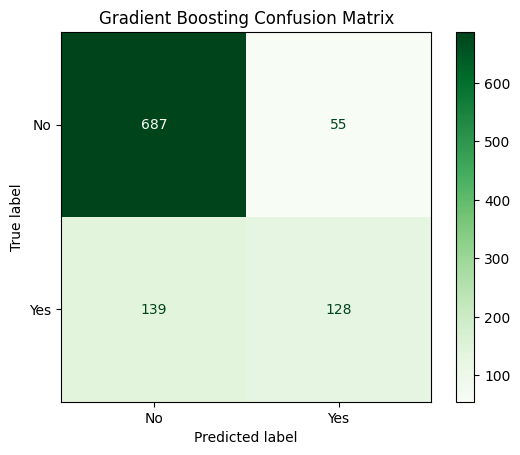

In [134]:
# Get confusion matrix values and display using confusion matrix display
gbc_cnf_matrix = confusion_matrix(y_eval_encoded, gbc_y_pred)
disp = ConfusionMatrixDisplay(gbc_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Greens')
plt.title('Gradient Boosting Confusion Matrix');

### Observation

The model makes 814 correct predictions while wrongly predicting 195 instances.

### Support Vector Machine Pipeline

In [135]:
SVM_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('classifier', SVC(probability=True, random_state=0))
])

SVM_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',
                                                                   columnDropper())...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen'])])),
                ('classifier', SVC(probability=True, random_state=0))])

In [136]:
# Get y predict values using svm pipeline
svm_y_pred = SVM_pipeline.predict(X_eval)

# Get classification report for true and predicted values
svm_report = classification_report(y_eval_encoded, svm_y_pred)

# Define model predictions for the model and true labels
svm_pred_proba = SVM_pipeline.predict_proba(X_eval)[:,1]

# Calculate FPR and TPR for the model
svm_fpr, svm_tpr, _ = roc_curve(y_eval_encoded, svm_pred_proba)

# Calculate AUC for the model
svm_auc_score = auc(svm_fpr, svm_tpr)

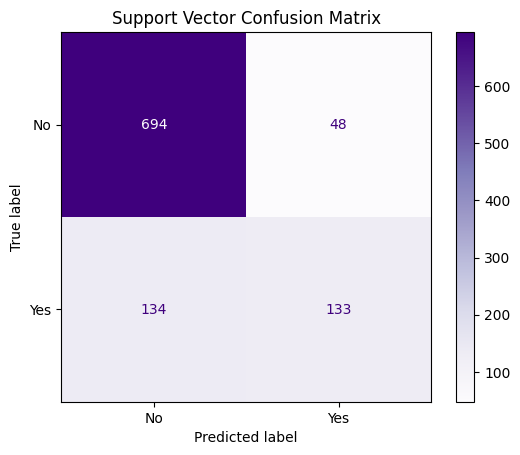

In [137]:
# Get confusion matrix values and display using confusion matrix display
svm_cnf_matrix = confusion_matrix(y_eval_encoded, svm_y_pred)
disp = ConfusionMatrixDisplay(svm_cnf_matrix,display_labels=label_encoder.classes_)
disp.plot(cmap='Purples')
plt.title('Support Vector Confusion Matrix');

This model makes 819 correct predictions and 190 wrong predictions.

## **Model Evaluation and Interpretation**

In [138]:
reports = [('RandomForest Classification:',rfc_report),
           ('DecisionTree Classification:',dtc_report),
           ('GradientBoosting Classification:',gbc_report),
           ('Support Vector Classification:',svm_report)
        ]

for label, report in reports:
    print(f'Report for {label}')
    print(report)
    print('_'*55)

Report for RandomForest Classification:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       742
           1       0.70      0.48      0.57       267

    accuracy                           0.81      1009
   macro avg       0.76      0.70      0.72      1009
weighted avg       0.80      0.81      0.79      1009

_______________________________________________________
Report for DecisionTree Classification:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       742
           1       0.52      0.51      0.52       267

    accuracy                           0.75      1009
   macro avg       0.67      0.67      0.67      1009
weighted avg       0.75      0.75      0.75      1009

_______________________________________________________
Report for GradientBoosting Classification:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       742
 

In summary, the models performs better in predicting class 0 (negative instances) than class 1 (positive instances) and this can be attributed to class imbalance. The F1-score balances precision and recall, and the weighted average provides an overall assessment. Further analysis and potential model improvements can focus on enhancing predictions for class 1.  

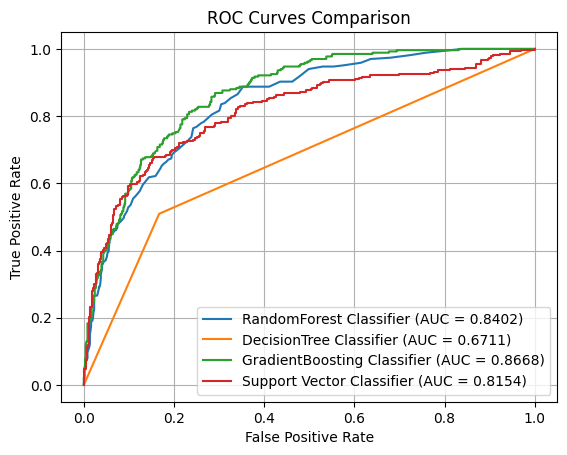

In [139]:
# Plot ROC curves
plt.plot(rfc_fpr, rfc_tpr, label=f'RandomForest Classifier (AUC = {rfc_auc_score:.4f})')
plt.plot(dtc_fpr, dtc_tpr, label=f'DecisionTree Classifier (AUC = {dtc_auc_score:.4f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'GradientBoosting Classifier (AUC = {gbc_auc_score:.4f})')
plt.plot(svm_fpr, svm_tpr, label=f'Support Vector Classifier (AUC = {svm_auc_score:.4f})')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The AUC score provides an indication of the model's prediction accuracy, with a score closer to 1.0 indicating better performance. Conversely, a score below 0.5 suggests poor model performance. The plot above shows that the GradientBoosting Classifier has the highest performance with an AUC of 86.7%. However, we cannot draw definitive conclusions since the dataset used for training was imbalanced. To ensure the best model selection for our project goals, we will balance the dataset and perform hyperparameter tuning. We are going to test two balancing methods and pick the best one.

In [140]:
# Put the name of the classifier and classifier into a list of tuples.
models = [
    ('RandomForest Classifier', RandomForestClassifier(random_state=0)),
    ('DecisionTree Classifier', DecisionTreeClassifier(random_state=0)),
    ('GradientBoosting Classifier', GradientBoostingClassifier(random_state=0)),
    ('SupportVector Classifier', SVC(probability=True, random_state=0))
]

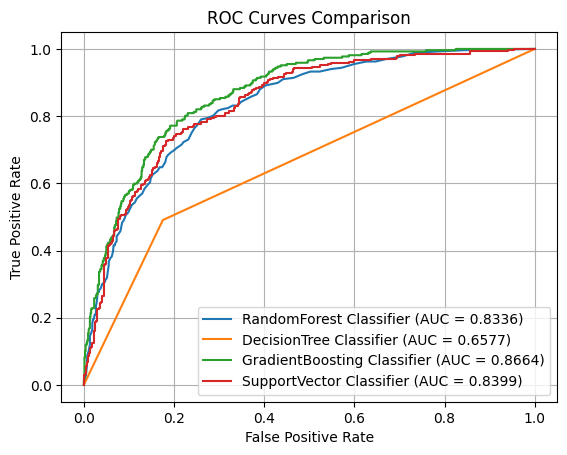

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.793855,0.788051,0.793855,0.790355
1,DecisionTree Classifier,0.736373,0.734492,0.736373,0.735406
2,GradientBoosting Classifier,0.790882,0.823059,0.790882,0.799643
3,SupportVector Classifier,0.780971,0.808869,0.780971,0.789356


In [141]:
random_sampler = RandomOverSampler(random_state=0)

all_models = {}
random_sampler_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])


# Loop through the model and classifier in the models list
for model, classifier in models:
    # Perform preprocessing and fit the respective models
    model_pipeline = Pipeline([
        ('sampler', random_sampler),
        ('preprocessor', full_pipeline),
        ('classifier', classifier)
    ])
    all_models[model] = classifier

    model_pipeline.fit(X_train, y_train_encoded)
    # Predict values of the evaluation dataset
    y_pred = model_pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    random_sampler_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = random_sampler_dict['accuracy']
    precision = random_sampler_dict['weighted avg']['precision']
    recall = random_sampler_dict['weighted avg']['recall']
    f1_score = random_sampler_dict['weighted avg']['f1-score']

    random_sampler_df.loc[len(random_sampler_df)] = [model, accuracy, precision, recall, f1_score]

    # Define model predictions for the model and true labels
    pred_proba = model_pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

random_sampler_df

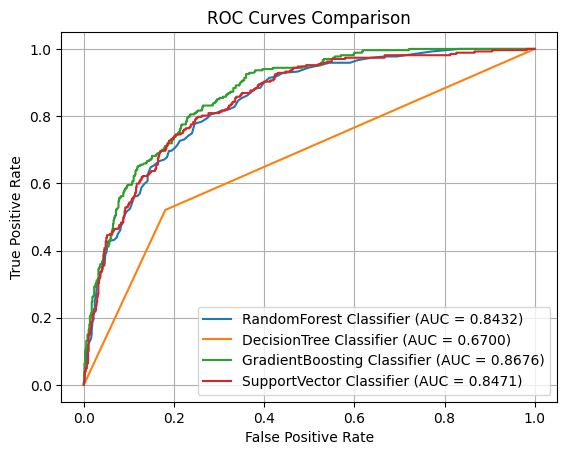

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.799802,0.791177,0.799802,0.793696
1,DecisionTree Classifier,0.740337,0.742222,0.740337,0.741252
2,GradientBoosting Classifier,0.807730,0.811670,0.807730,0.809479
3,SupportVector Classifier,0.789891,0.804569,0.789891,0.795222


In [142]:
# Create instance of smote
smote_sampler = SMOTE(random_state=0)

smote_sampler_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])

# Loop through the classification models and fit them for all the models
for model, classifier in models:
    pipeline = Pipeline([
        ('preprocessor', full_pipeline),
        ('sampler', smote_sampler),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)
    
    # Pred y values for the evaluate dataset
    y_pred = pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    smote_sampler_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = smote_sampler_dict['accuracy']
    precision = smote_sampler_dict['weighted avg']['precision']
    recall = smote_sampler_dict['weighted avg']['recall']
    f1_score = smote_sampler_dict['weighted avg']['f1-score']

    smote_sampler_df.loc[len(smote_sampler_df)] = [model, accuracy, precision, recall, f1_score]
   # Define model predictions for the model and true labels
    pred_proba = pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')
    
# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

smote_sampler_df

- Comparing the two balancing methods, SMOTE seems to outperform the Random Oversampler, as the F1-score and AUC score are slightly higher that from the Random Oversampler, therefore SMOTE is the sampling method we are going with.

- The best performing models are The GradientBoosting Classifier and SVN classifier, with higher F1-scores and AUC scores as compared to the others.

### **Feature Selection**

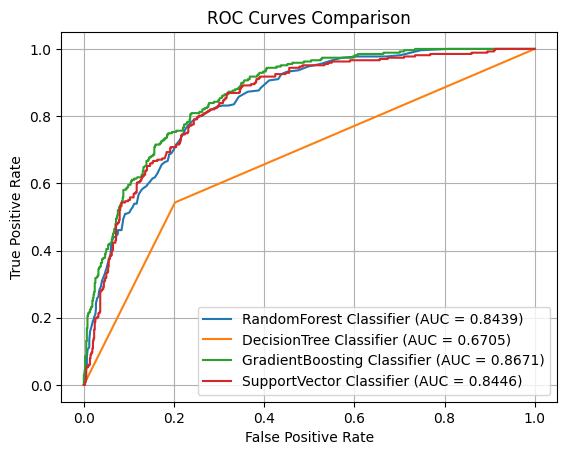

,Model,Accuracy,Precision,Recall,f1-score
0,RandomForest Classifier,0.795837,0.790107,0.795837,0.792371
1,DecisionTree Classifier,0.730426,0.739795,0.730426,0.734549
2,GradientBoosting Classifier,0.807730,0.813274,0.807730,0.810088
3,SupportVector Classifier,0.778989,0.797260,0.778989,0.785408


In [143]:
# Select best performing features from list of features in the dataset
best_feature_selectors = SelectKBest(score_func=partial(mutual_info_classif, random_state=0),k=25)

feature_selected_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score'])

for model, classifier in models:
    pipeline = Pipeline([
        ('preprocessor', full_pipeline),
        ('sampler', smote_sampler),
        ('feature_selection', best_feature_selectors),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)
    
    y_pred = pipeline.predict(X_eval)

    # Print accuracy, precision, recall, and f1-score for all the models
    feature_selected_dict = classification_report(y_eval_encoded, y_pred, output_dict=True)

    accuracy = feature_selected_dict['accuracy']
    precision = feature_selected_dict['weighted avg']['precision']
    recall = feature_selected_dict['weighted avg']['recall']
    f1_score = feature_selected_dict['weighted avg']['f1-score']

    feature_selected_df.loc[len(feature_selected_df)] = [model, accuracy, precision, recall, f1_score]
   # Define model predictions for the model and true labels
    pred_proba = pipeline.predict_proba(X_eval)[:,1]
    # Calculate FPR and TPR for the model
    fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
    # Calculate AUC for the model
    auc_score = auc(fpr, tpr)

    # Plot ROC curves
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')
    
# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

feature_selected_df

There is a significant change in the values of the f1-score for all the models. We also view the ROC curve and observe what it depicts. The performance of the GradientBoosting classifier has been consistent with its performance on both balanced and imbalanced datasets and will be selected for our prediction model. However, we want to see if the model can perform even better when we hyperparameter-tune the model.

In [144]:
feature_indices = best_feature_selectors.get_support(indices=True)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

print(feature_indices)
pd.DataFrame(feature_names[feature_indices], columns=['features'])

[ 0  1  2  3  5  6  7  8 14 15 16 17 19 22 23 28 29 30 31 32 33 34 35 37
 38]


,features
0,num_pipeline__tenure
1,num_pipeline__MonthlyCharges
2,num_pipeline__TotalCharges
3,cat_pipeline__gender_Female
4,cat_pipeline__Partner_No
5,cat_pipeline__Partner_Yes
6,cat_pipeline__Dependents_No
7,cat_pipeline__Dependents_Yes
8,cat_pipeline__InternetService_Fiber optic
9,cat_pipeline__InternetService_No


## **Hyperparameter Tuning**

### GradientBoosting Classifier

In [145]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': randint(1, 200),
    'classifier__max_features': randint(1, 50),
    'classifier__max_depth': randint(1, 20),
    'classifier__learning_rate': uniform(0.01, 0.5)
}

In [146]:
gb_classifier = all_models['GradientBoosting Classifier']
# Create the GradientBoostingClassifier
gb_classifier_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('smote', smote_sampler),
    ('feature_selection', best_feature_selectors),
    ('classifier', gb_classifier)
    ])

# Define model predictions for the model and true labels
pred_proba = gb_classifier_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
# Calculate AUC for the model
auc_score = auc(fpr, tpr)

# Create RandomizedSearchCV instance
random_search = RandomizedSearchCV(gb_classifier_pipeline, param_distributions=param_dist, n_iter=50, cv=5, random_state=0, verbose=2, n_jobs=-1)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('total_charges_cleaner',
                                                                                                TotalCharges_cleaner()),
                                                                                               ('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('pt_transform',
                                                                                                PowerTransformer()),
                                                                                               ('scaling',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges']),
                                                                              ('cat_pipeline',
                                                                               Pipeline(steps=[...
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C2C83F0E30>,
                                        'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C2C8326090>,
                                        'classifier__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C2BEE8B470>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C2BEE8BA70>},
                   random_state=0, verbose=2)

In [147]:
pd.DataFrame(zip(fpr, tpr, threshold),columns=['False positive', 'True positive', 'Threshold']).tail(115)

,False positive,True positive,Threshold
214,0.320755,0.865169,0.253600
215,0.320755,0.872659,0.251639
216,0.330189,0.872659,0.240989
217,0.330189,0.876404,0.240140
218,0.335580,0.876404,0.236696
...,...,...,...
324,0.978437,1.000000,0.013468
325,0.983827,1.000000,0.013199
326,0.989218,1.000000,0.012646
327,0.991914,1.000000,0.012614


In [148]:
best_parameters = random_search.best_params_
best_parameters

{'classifier__learning_rate': 0.33983420603470643,
 'classifier__max_depth': 2,
 'classifier__max_features': 41,
 'classifier__n_estimators': 161}

In [149]:
gb_classifier_pipeline.set_params(**best_parameters)
gb_classifier_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',
                                                                   columnDropper())...
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen'])])),
                ('smote', SMOTE(random_state=0)),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=functools.partial(<function mutual_info_classif at 0x000001C2B6DEF4C0>, random_state=0))),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.33983420603470643,
                                            max_depth=2, max_features=41,
                                            n_estimators=161,
                                            random_state=0))])

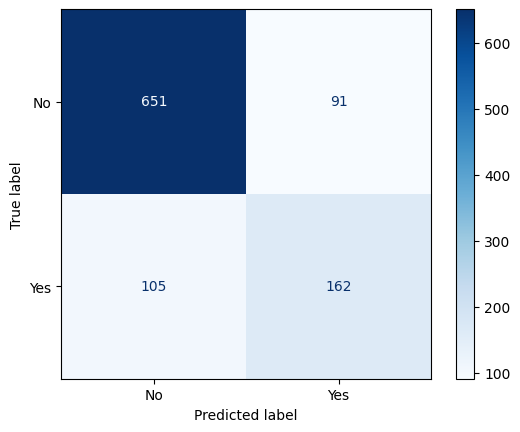

In [150]:
predic = gb_classifier_pipeline.predict(X_eval)
conf = confusion_matrix(y_eval_encoded, predic)

ConfusionMatrixDisplay(conf, display_labels=label_encoder.classes_).plot(cmap='Blues');

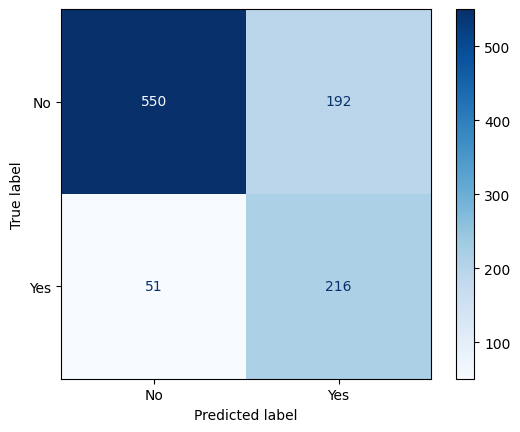

In [151]:
threshold_ = 0.276767

y_predic_proba = gb_classifier_pipeline.predict_proba(X_eval)[:,1]

binary_classification = (y_predic_proba >= threshold_)

threshold_matrix = confusion_matrix(y_eval_encoded, binary_classification)
ConfusionMatrixDisplay(threshold_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues');

### SupportVector Classifier

In [152]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__C': [1, 5, 10],
    'classifier__gamma': [0.1, 1, 'auto'],
    'classifier__degree': [1,2,3]
}

In [153]:
sv_classifier = all_models['SupportVector Classifier']
# Create the GradientBoostingClassifier
sv_classifier_pipeline = Pipeline([
    ('preprocessor', full_pipeline),
    ('smote', smote_sampler),
    ('feature_selection', best_feature_selectors),
    ('classifier', sv_classifier)
    ])

# Define model predictions for the model and true labels
pred_proba = sv_classifier_pipeline.predict_proba(X_eval)[:,1]
# Calculate FPR and TPR for the model
fpr, tpr, threshold = roc_curve(y_eval_encoded, pred_proba)
# Calculate AUC for the model
auc_score = auc(fpr, tpr)

# Create GridSearchCV instance
grid_search = GridSearchCV(sv_classifier_pipeline, param_grid=param_grid, verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=   9.0s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=   8.3s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=   7.9s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=   7.7s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=0.1; total time=   6.5s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=   8.9s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=   9.2s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=   9.1s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=   8.6s
[CV] END classifier__C=1, classifier__degree=1, classifier__gamma=1; total time=  11.1s
[CV] END classifier__C=1, classifier__degree=1, 

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('total_charges_cleaner',
                                                                                          TotalCharges_cleaner()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('pt_transform',
                                                                                          PowerTransformer()),
                                                                                         ('scaling',
                                                                                          StandardScaler())]),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('column_dr...
                                                                          'SeniorCitizen'])])),
                                       ('smote', SMOTE(random_state=0)),
                                       ('feature_selection',
                                        SelectKBest(k=25,
                                                    score_func=functools.partial(<function mutual_info_classif at 0x000001C2B6DEF4C0>, random_state=0))),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=0))]),
             param_grid={'classifier__C': [1, 5, 10],
                         'classifier__degree': [1, 2, 3],
                         'classifier__gamma': [0.1, 1, 'auto']},
             verbose=2)

In [154]:
pd.DataFrame(zip(fpr, tpr, threshold),columns=['False positive', 'True positive', 'Threshold']).tail(70)

,False positive,True positive,Threshold
178,0.300539,0.838951,0.208223
179,0.308625,0.838951,0.205558
180,0.308625,0.846442,0.204896
181,0.311321,0.846442,0.202912
182,0.311321,0.850187,0.202832
...,...,...,...
243,0.909704,0.992509,0.064478
244,0.909704,0.996255,0.064304
245,0.912399,0.996255,0.063964
246,0.912399,1.000000,0.063873


In [155]:
best_parameters = grid_search.best_params_
best_parameters

{'classifier__C': 5, 'classifier__degree': 1, 'classifier__gamma': 0.1}

In [156]:
sv_classifier_pipeline.set_params(**best_parameters)
sv_classifier_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('total_charges_cleaner',
                                                                   TotalCharges_cleaner()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('pt_transform',
                                                                   PowerTransformer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('column_dropper',
                                                                   columnDropper())...
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen'])])),
                ('smote', SMOTE(random_state=0)),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=functools.partial(<function mutual_info_classif at 0x000001C2B6DEF4C0>, random_state=0))),
                ('classifier',
                 SVC(C=5, degree=1, gamma=0.1, probability=True,
                     random_state=0))])

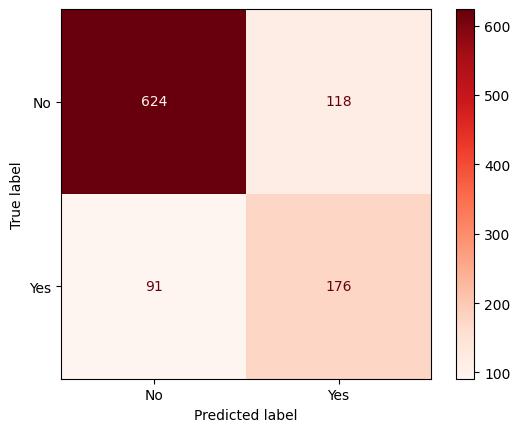

In [157]:
predic = sv_classifier_pipeline.predict(X_eval)
conf = confusion_matrix(y_eval_encoded, predic)

ConfusionMatrixDisplay(conf, display_labels=label_encoder.classes_).plot(cmap='Reds');

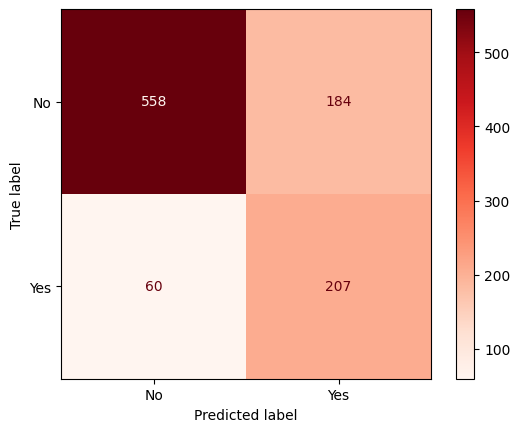

In [158]:
threshold_ = 0.253424

y_predic_proba = sv_classifier_pipeline.predict_proba(X_eval)[:,1]

binary_classification = (y_predic_proba >= threshold_)

threshold_matrix = confusion_matrix(y_eval_encoded, binary_classification)
ConfusionMatrixDisplay(threshold_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds');

## **Prediction on Test Dataset**

### GradientBoosting Classifier

In [159]:
test_prediction = gb_classifier_pipeline.predict(df_test)
test_prediction_r = pd.Series(label_encoder.inverse_transform(test_prediction))

In [161]:
test_prediction_r.value_counts()

No     1443
Yes     557
Name: count, dtype: int64

The GradientBoosting model is used to predict the churn status of customers for the test dataset. The number of customers that didn't churn were 1,443 and those who churned were 557.

### SupportVector Classifier

In [162]:
test_prediction = sv_classifier_pipeline.predict(df_test)
test_prediction_r = pd.Series(label_encoder.inverse_transform(test_prediction))

In [163]:
test_prediction_r.value_counts()

No     1358
Yes     642
Name: count, dtype: int64

The SupportVector model is used to predict the churn status of customers for the test dataset. The number of customers that didn't churn were 1,358 and those who churned were 642.

### **Model Persistence**

In [168]:
# Define the directory where the models will be saved
model_dir = '../model/'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the models
joblib.dump(gb_classifier_pipeline, os.path.join(model_dir, 'GradientBoosting.joblib'))
joblib.dump(sv_classifier_pipeline, os.path.join(model_dir, 'SupportVector.joblib'))
joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.joblib'))

['../model/label_encoder.joblib']